#  <span style="color: #f00;"> PROJET Numéro 7: Implémentez un modèle de scoring </span> 

# Notebook 1: Notebook de préparation du jeu de données et de feature engineering et de l'analyse exploratoire

# Introduction: Home Credit Default Risk Competition

This notebook is intended for those who are new to machine learning competitions or want a gentle introduction to the problem. I purposely avoid jumping into complicated models or joining together lots of data in order to show the basics of how to get started in machine learning! Any comments or suggestions are much appreciated.

In this notebook, we will take an initial look at the Home Credit default risk machine learning competition currently hosted on Kaggle. The objective of this competition is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task:

* __Supervised__: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
* __Classification__: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)


# Data

The data is provided by [Home Credit](http://www.homecredit.net/about-us.aspx), a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task. 

There are 7 different sources of data:

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 
* bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length. 
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature `SK_ID_PREV`. 
* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. 

This diagram shows how all of the data is related:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

Moreover, we are provided with the definitions of all the columns (in `HomeCredit_columns_description.csv`) and an example of the expected submission file. 

In this notebook, we will stick to using only the main application training and testing data. Although if we want to have any hope of seriously competing, we need to use all the data, for now we will stick to one file which should be more manageable. This will let us establish a baseline that we can then improve upon. With these projects, it's best to build up an understanding of the problem a little at a time rather than diving all the way in and getting completely lost! 

## Metric: ROC AUC

Once we have a grasp of the data (reading through the [column descriptions](https://www.kaggle.com/c/home-credit-default-risk/data) helps immensely), we need to understand the metric by which our submission is judged. In this case, it is a common classification metric known as the [Receiver Operating Characteristic Area Under the Curve (ROC AUC, also sometimes called AUROC)](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it).

The ROC AUC may sound intimidating, but it is relatively straightforward once you can get your head around the two individual concepts. The [Reciever Operating Characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) graphs the true positive rate versus the false positive rate:

![image](http://www.statisticshowto.com/wp-content/uploads/2016/08/ROC-curve.png)

A single line on the graph indicates the curve for a single model, and movement along a line indicates changing the threshold used for classifying a positive instance. The threshold starts at 0 in the upper right to and goes to 1 in the lower left. A curve that is to the left and above another curve indicates a better model. For example, the blue model is better than the red model, which is better than the black diagonal line which indicates a naive random guessing model. 

The [Area Under the Curve (AUC)](http://gim.unmc.edu/dxtests/roc3.htm) explains itself by its name! It is simply the area under the ROC curve. (This is the integral of the curve.) This metric is between 0 and 1 with a better model scoring higher. A model that simply guesses at random will have an ROC AUC of 0.5.

When we measure a classifier according to the ROC AUC, we do not generation 0 or 1 predictions, but rather a probability between 0 and 1. This may be confusing because we usually like to think in terms of accuracy, but when we get into problems with inbalanced classes (we will see this is the case), accuracy is not the best metric. For example, if I wanted to build a model that could detect terrorists with 99.9999% accuracy, I would simply make a model that predicted every single person was not a terrorist. Clearly, this would not be effective (the recall would be zero) and we use more advanced metrics such as ROC AUC or the [F1 score](https://en.wikipedia.org/wiki/F1_score) to more accurately reflect the performance of a classifier. A model with a high ROC AUC will also have a high accuracy, but the [ROC AUC is a better representation of model performance.](https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy)

Not that we know the background of the data we are using and the metric to maximize, let's get into exploring the data. In this notebook, as mentioned previously, we will stick to the main data sources and simple models which we can build upon in future work. 

__Follow-up Notebooks__

For those looking to keep working on this problem, I have a series of follow-up notebooks:

* [Manual Feature Engineering Part One](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering)
* [Manual Feature Engineering Part Two](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2)
* [Introduction to Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/automated-feature-engineering-basics)
* [Advanced Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/tuning-automated-feature-engineering-exploratory)
* [Feature Selection](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
* [Intro to Model Tuning: Grid and Random Search](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search)
* [Automated Model Tuning](https://www.kaggle.com/willkoehrsen/automated-model-tuning)
* [Model Tuning Results](https://www.kaggle.com/willkoehrsen/model-tuning-results-random-vs-bayesian-opt/notebook)


I'll add more notebooks as I finish them! Thanks for all the comments! 

# Première partie: Traitement et analyses des données

## <span style="color: ##0101DF;">Importation des bibliothèques </span> 

In [1]:
import sys   
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
print('Python',sys.version)

import pandas as pd
print('Pandas',pd.__version__)
pd.options.mode.chained_assignment = None

import numpy as np
print('Numpy',np.__version__)

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
print('Matplotlib',matplotlib.__version__)

import seaborn as sns
sns.set(style="darkgrid")
print('Seaborn',sns.__version__)

from IPython.display import Image, HTML
from wordcloud import WordCloud, STOPWORDS

from sklearn.metrics.pairwise import linear_kernel

import tqdm
import time
from time import strftime, gmtime
from pprint import pprint
import squarify
import random
from IPython.display import Markdown

import pickle
import joblib
from joblib import dump, load

import lightgbm as lgb
print('lightgbm',lgb.__version__)

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

Python 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Pandas 1.2.4
Numpy 1.20.1
Matplotlib 3.3.4
Seaborn 0.11.1
lightgbm 3.3.1


In [2]:
#Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', -1)

## <span style="color: ##0101DF;">Quelques fonctions utiles </span> 

### Temps de calcul

In [3]:
# list_elapsed = []
# list_elapsed_mem = [] # Mémorisation d'un résultat
# list_ope = []

# def time_calc(ope='dernière operation', elapsed_mem='', print_tot=0, print_all=0):
    
#     elapsed = round((time.time() - t),2)
    
#     if ope != 'dernière operation':
#         print('Durée de l\'opération %r:' %ope, round(elapsed,2),'s')
#     else:
#         print('Durée de l\'opération:', round(elapsed,2),'s')
    
#     list_elapsed.extend([elapsed])
#     list_elapsed_mem.extend([elapsed_mem])
#     list_ope.extend([ope])
#     tot_duration = sum(list_elapsed)
#     df_time = pd.DataFrame({'Opération': list_ope, 'Durée': list_elapsed, 'Estimation': list_elapsed_mem})

#     if print_tot == 1:
#         print('Durée totale de traitement:',strftime('%H', gmtime(tot_duration)),'h',
#               strftime('%M', gmtime(tot_duration)),'m',strftime('%S', gmtime(tot_duration)),'s')
    
#     if print_all == 1:
#         print('')
#         print('Durée des opérations')
#         print(len('Durée des opérations')*'-')
#         print(df_time)  

### Caractéristiques des features d'un DataFrame

In [4]:
# Déclaration des listes vides
list_dataset = []
list_shape = []
list_variable = []
list_duplicates = []
list_unique = []
list_null = []
list_null_ratio = []
list_type = []

# Dictionnaire des listes
dic_var_info = {'Dataset': list_dataset,
                'Shape': list_shape,
                'Variable': list_variable,
                'Duplicates': list_duplicates,
                'Unique': list_unique,
                'Null': list_null,
                'Null_ratio': list_null_ratio,
                'Type': list_type}


def var_info(df,df_name,var,print_=0,n=5):
    
    list_dataset.append(df_name)
    list_shape.append(df.shape[0])
    list_variable.append(var)
    list_duplicates.append(df.duplicated(subset=[var]).sum())
    list_unique.append(df[var].unique().shape[0])
    list_null.append(df[var].isna().sum().sum())
    list_null_ratio.append((df[var].isna().sum().sum())/df.shape[0])
    list_type.append(df[var].dtypes)
    
    df_data_model = pd.DataFrame(dic_var_info)
    
    if print_ == 1:
        varInfo = df_data_model.tail(n)
        return varInfo
    
    
def all_var_info(df,df_name):    
    
    last_value = df.columns.tolist()[len(df.columns.tolist())-1]
    for i in df.columns.tolist():
        if i != last_value:
            var_info(df,df_name,i)
    return var_info(df,df_name,last_value,1,df.shape[1])

In [5]:
# def val_out(df_ref,var_01,var_01_max='',var_01_min=0):
#     """Fonction d'identification de valeurs abberantes"""
    
#     df = df_ref.copy()
#     df = df[[var_01]]
    
#     if var_01_max != '':
#         df = df[(df[var_01] >= var_01_min) & (df[var_01] <= var_01_max)]
#     else:
#         df = df
    
#     print(df.describe())  
#     df.plot(kind='box', figsize=(3,4), color="black")

In [6]:
def select_col_by_type(df,col_type) : 
    var_object = []
    for col in df.select_dtypes(col_type) :
        var_object.append(col)
    return var_object

def missing_presence(df, figsize):
    
    # Affichage de la forme du dataset
    print("Le dataset contient {} lignes et {} colonnes.".format(df.shape[0], df.shape[1]))
    
    # Proportion de valeurs nulles
    prop_nan_df = df.isna().sum().sum()/(df.shape[0]*df.shape[1])*100
    print('Il y a {:.2f}% de NaN.'.format(prop_nan_df))
    
    # Visualisation des valeurs non nulles
    df_null=(df.notnull().sum()/df.shape[0]).sort_values(ascending=False)*100
    
    # Création de la figure
    plt.figure(figsize=figsize)
    plt.style.use('ggplot')
    ax=sns.barplot(x=df_null.values, y=df_null.index, orient='h')
    plt.title('Proportion de valeurs présentes par colonne')
    plt.xticks(rotation=0)
    plt.yticks(fontsize=14)
    plt.ylabel("Nom de la colonne")
    plt.xlabel('Pourcentage de valeurs présentes (%)')

    # Affichage de la valeur à côté des barres
    for index, value in enumerate(df_null.values):
        plt.text(value, index+0.4, str(value.round(2)))

    plt.show()
    
def setup_plot():
    plt.rcParams["axes.grid.axis"] = "y"
    plt.rcParams["axes.grid"] = True
    plt.rcParams["legend.fontsize"] = 14
    plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
    plt.rcParams["xtick.labelsize"] = 15
    plt.rcParams["ytick.labelsize"] = 15

def select_col_by_type(df,col_type) : 
    var_object = []
    for col in df.select_dtypes(col_type) :
        var_object.append(col)
    return var_object
def handle_type(df) :
    cat_var = select_col_by_type(df,"object")
    int_var = select_col_by_type(df,"int")
    float_var = select_col_by_type(df,"float")
    num_var = int_var + float_var
    return cat_var, num_var
def imputer_nan(df, strategy, var_type):
    imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputer = imputer.fit(df[var_type])
    array_type = imputer.transform(df[var_type])
    df_type = pd.DataFrame(array_type, columns=var_type)
    return df_type

def trans_func():
    control_train = pd.read_csv(data_path +'application_train.csv')
    train_data = control_train[control_train.columns[control_train.isna().sum()/control_train.shape[0] < 0.8]]
    cat_var, num_var = handle_type(train_data)
    df_cat = imputer_nan(train_data, "most_frequent", cat_var)
    df_num = imputer_nan(train_data, "median", num_var)
    dummies = pd.get_dummies(df_cat, drop_first=True)
    concatenate_df = pd.concat([df_num, dummies], axis=1)
    data = concatenate_df.sample(n=500, random_state=1)
    return data

In [7]:
# Chemin d'accès aux fichiers de données csv
path_data_csv = "C:/Users/Agboto/Desktop/Projet_OpenClassrooms_Data_Science/Projet7_openclassrooms/data_csv/"
# Chemin d'export des données après traitement
path_data = "C:/Users/Agboto/Desktop/Projet_OpenClassrooms_Data_Science/Projet7_openclassrooms/"

# <span style="color: ##0101DF;"> Importation des jeux de données </span> 

In [8]:
application_test = pd.read_csv(path_data_csv+'application_test.csv',encoding='utf-8',low_memory=False)
application_train = pd.read_csv(path_data_csv+'application_train.csv',encoding='utf-8',low_memory=False)
bureau = pd.read_csv(path_data_csv+'bureau.csv',encoding='utf-8',low_memory=False)
bureau_balance = pd.read_csv(path_data_csv+'bureau_balance.csv',encoding='utf-8',low_memory=False)
credit_card_balance = pd.read_csv(path_data_csv+'credit_card_balance.csv',encoding='utf-8',low_memory=False)
HomeCredit_columns_description = pd.read_csv(path_data_csv+'HomeCredit_columns_description.csv',low_memory=False)
installments_payments = pd.read_csv(path_data_csv+'installments_payments.csv',encoding='utf-8',low_memory=False)
POS_CASH_balance = pd.read_csv(path_data_csv+'POS_CASH_balance.csv',encoding='utf-8',low_memory=False)
previous_application = pd.read_csv(path_data_csv+'previous_application.csv',encoding='utf-8',low_memory=False)
sample_submission = pd.read_csv(path_data_csv+'sample_submission.csv',encoding='utf-8',low_memory=False)

In [9]:
# t = time.time()
# application_test = pd.read_csv('application_test.csv')
# print("application_test: %s observations and %s variables"%application_test.shape)
# print('==========================================================================')
# application_train = pd.read_csv('application_train.csv')
# print("application_train: %s observations and %s variables"%application_train.shape)
# print('==========================================================================')
# bureau = pd.read_csv('bureau.csv')
# print("bureau: %s observations and %s variables"%bureau.shape)
# print('==========================================================================')
# bureau_balance = pd.read_csv('bureau_balance.csv')
# print("bureau_balance: %s observations and %s variables"%bureau_balance.shape)
# print('==========================================================================')
# credit_card_balance = pd.read_csv('credit_card_balance.csv')
# print("credit_card_balance: %s observations and %s variables"%credit_card_balance.shape)
# print('==========================================================================')
# HomeCredit_columns_description = pd.read_csv('HomeCredit_columns_description.csv')
# print("HomeCredit_columns_description: %s observations and %s variables"%HomeCredit_columns_description.shape)
# print('==========================================================================')
# installments_payments = pd.read_csv('installments_payments.csv')
# print("installments_payments: %s observations and %s variables"%installments_payments.shape)
# print('==========================================================================')
# POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
# print("POS_CASH_balance: %s observations and %s variables"%POS_CASH_balance.shape)
# print('==========================================================================') 
# previous_application = pd.read_csv('previous_application.csv')
# print("previous_application: %s observations and %s variables"%previous_application.shape)
# print('==========================================================================')
# sample_submission = pd.read_csv('sample_submission.csv')
# print("sample_submission: %s observations and %s variables"%sample_submission.shape)
# time_calc('Importation des données (import csv)') # fonction temps de calcul
# t = time.time()

### Commentaire sur les jeux de données
Tout d'abord, nous pouvons lister tous les fichiers de données disponibles. Il y a au total **9 fichiers** : 
* 1 Dataset entraînement pour l'entraînement(avec cible, 0: le client est **solvable**; 1: le client est **non solvable**), 1 Dataset test pour les tests (sans la cible), 
* 1 Dataset d'exemple de soumission,
* 1 dataset des métadonnées,
* et 6 autres Datasets contenant des informations complémentaires sur les prêts du client.

### application_{train|test}.csv (application_{train|test}.csv)
Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.


### bureau.csv (bureau.csv)
Tous les crédits antérieurs des clients fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients qui ont un prêt dans notre échantillon).
Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le bureau de crédit avant la date de la demande.


### bureau_balance.csv (bureau_balance.csv)
Soldes mensuels des crédits précédents dans Credit Bureau.
Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable pour les crédits précédents) lignes .


### POS_CASH_balance.csv (POS_CASH_balance.csv)
Instantanés du solde mensuel des précédents POS (points de vente) et des prêts en espèces que le demandeur avait avec Home Credit.
Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans laquelle nous avons un historique observable pour les crédits précédents).


### credit_card_balance.csv (credit_card_balance.csv)
Instantanés du solde mensuel des cartes de crédit précédentes que le demandeur a avec Home Credit.
Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour les lignes de carte de crédit précédentes).


### application_précédente.csv (previous_application.csv)
Toutes les demandes antérieures de crédit immobilier des clients qui ont des crédits dans notre échantillon.
Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.


### versements_paiements.csv (installments_payments.csv)
Historique de remboursement des crédits précédemment décaissés en Crédit Logement relatifs aux crédits de notre échantillon.
Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué.
Une ligne équivaut à un versement d'une échéance OU une échéance correspondant à un versement d'un précédent crédit Home Credit lié aux crédits de notre échantillon.


### AccueilCredit_columns_description.csv (HomeCredit_columns_description.csv), méta données
Ce fichier contient les descriptions des colonnes des différents fichiers de données. 

In [10]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,...,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
all_var_info(application_train.iloc[:,0:15],'application_train')

,Dataset,Shape,Variable,Duplicates,Unique,Null,Null_ratio,Type
0,application_train,307511,SK_ID_CURR,0,307511,0,0.000000,int64
1,application_train,307511,TARGET,307509,2,0,0.000000,int64
2,application_train,307511,NAME_CONTRACT_TYPE,307509,2,0,0.000000,object
3,application_train,307511,CODE_GENDER,307508,3,0,0.000000,object
4,application_train,307511,FLAG_OWN_CAR,307509,2,0,0.000000,object
5,application_train,307511,FLAG_OWN_REALTY,307509,2,0,0.000000,object
6,application_train,307511,CNT_CHILDREN,307496,15,0,0.000000,int64
7,application_train,307511,AMT_INCOME_TOTAL,304963,2548,0,0.000000,float64
8,application_train,307511,AMT_CREDIT,301908,5603,0,0.000000,float64
9,application_train,307511,AMT_ANNUITY,293838,13673,12,0.000039,float64


Les données d'apprentissage comptent: **307511 observations (chacune un prêt séparé) et 122 caractéristiques (variables) y compris la CIBLE (l'étiquette que nous voulons prédire)**. 

In [12]:
application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Les données de test sont considérablements plus petites et n'ont pas de colonne TARGET (CIBLE). 

In [13]:
set(application_train.columns)-set(application_test.columns)

{'TARGET'}

0 SK_ID_CURR ID du prêt dans notre échantillon

1 CIBLE Variable cible (1 - client en difficulté de paiement : il a eu plus de X jours de retard de paiement sur au moins une des Y premières échéances du crédit dans notre échantillon, 0 - tous les autres cas)

2 NAME_CONTRACT_TYPE Identification si prêt en espèces ou renouvelable

3 CODE_GENDER Sexe du client

4 FLAG_OWN_CAR Indicateur si le client possède une voiture

5 FLAG_OWN_REALTY Indicateur si le client possède une maison ou un appartement

6 CNT_CHILDREN Nombre d'enfants que le client a

7 AMT_INCOME_TOTAL Revenu du client

8 AMT_CREDIT Montant du crédit du prêt

9 AMT_ANNUITY Rente de prêt

10 AMT_GOODS_PRICE Pour les crédits à la consommation c'est le prix des biens pour lesquels le crédit est accordé

11 NAME_TYPE_SUITE Qui accompagnait le client lors de sa demande de prêt

12 NAME_INCOME_TYPE Type de revenu du client (homme d'affaires, travail, congé de maternité,�)

13 NAME_EDUCATION_TYPE Niveau d'études le plus élevé atteint par le client

14 NAME_FAMILY_STATUS Situation familiale du client

15 NAME_HOUSING_TYPE Quelle est la situation de logement du client (location, cohabitation avec les parents, ...)

16 REGION_POPULATION_RELATIVE Population normalisée de la région où vit le client (un nombre plus élevé signifie que le client
vit dans une région plus peuplée)

17 DAYS_BIRTH Âge du client en jours au moment de la demande

18 DAYS_EMPLOYED Combien de jours avant la demande la personne a commencé son emploi actuel

19 DAYS_REGISTRATION Combien de jours avant l'application le client a-t-il modifié son inscription

20 DAYS_ID_PUBLISH Combien de jours avant la demande le client a-t-il modifié la pièce d'identité avec laquelle il a demandé le prêt

21 OWN_CAR_AGE Âge de la voiture du client

22 FLAG_MOBIL Le client a-t-il fourni un téléphone portable (1=OUI, 0=NON)

23 FLAG_EMP_PHONE Le client a-t-il fourni un téléphone au travail (1=OUI, 0=NON)

24 FLAG_WORK_PHONE Le client a-t-il fourni un téléphone fixe (1=OUI, 0=NON)

25 FLAG_CONT_MOBILE Le téléphone portable était-il joignable (1=OUI, 0=NON)

26 FLAG_PHONE Le client a-t-il fourni le téléphone résidentiel (1=OUI, 0=NON)

27 FLAG_EMAIL Le client a-t-il fourni un e-mail (1=OUI, 0=NON)

28 OCCUPATION_TYPE Quel type d'occupation le client a-t-il

29 CNT_FAM_MEMBERS Combien de membres de la famille le client a-t-il

30 REGION_RATING_CLIENT Notre note de la région où habite le client (1,2,3)

31 REGION_RATING_CLIENT_W_CITY Notre notation de la région où habite le client avec prise en compte de la ville (1,2,3)

32 WEEKDAY_APPR_PROCESS_START Quel jour de la semaine le client a-t-il demandé le prêt

33 HOUR_APPR_PROCESS_START Environ à quelle heure le client a-t-il demandé le prêt

34 REG_REGION_NOT_LIVE_REGION Indicateur si l'adresse permanente du client ne correspond pas à l'adresse de contact (1=différent, 0=même, au niveau de la région)

35 REG_REGION_NOT_WORK_REGION Indicateur si l'adresse permanente du client ne correspond pas à l'adresse professionnelle (1=différent, 0=même, au niveau de la région)

36 LIVE_REGION_NOT_WORK_REGION Indicateur si l'adresse de contact du client ne correspond pas à l'adresse professionnelle (1=différent, 0=même, au niveau de la région)

37 REG_CITY_NOT_LIVE_CITY Indicateur si l'adresse permanente du client ne correspond pas à l'adresse de contact (1=différent, 0=même, au niveau de la ville)

38 REG_CITY_NOT_WORK_CITY Indicateur si l'adresse permanente du client ne correspond pas à l'adresse professionnelle (1=différent, 0=même, au niveau de la ville)

39 LIVE_CITY_NOT_WORK_CITY Indicateur si l'adresse de contact du client ne correspond pas à l'adresse du travail (1=différent, 0=même, au niveau de la ville)

40 ORGANIZATION_TYPE Type d'organisation où le client travaille

41 EXT_SOURCE_1 Score normalisé à partir d'une source de données externe

42 EXT_SOURCE_2 Score normalisé à partir d'une source de données externe

43 EXT_SOURCE_3 Score normalisé à partir d'une source de données externe

44 APARTMENTS_AVG Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge de l'immeuble, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

45 BASEMENTAREA_AVG Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

46 YEARS_BEGINEXPLUATATION_AVG Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

47 YEARS_BUILD_AVG Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

48 COMMONAREA_AVG Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage 

49 ELEVATORS_AVG Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

50 ENTRANCES_AVG Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

51 FLOORSMAX_AVG Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

52 FLOORSMIN_AVG Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

53 LANDAREA_AVG Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

54 LIVINGAPARTMENTS_AVG Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille moyenne de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

55 LIVINGAREA_AVG Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

56 NONLIVINGAPARTMENTS_AVG Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille moyenne de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

57 NONLIVINGAREA_AVG Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille moyenne de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

58 APARTMENTS_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille moyenne de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

59 BASEMENTAREA_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille moyenne de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

60 YEARS_BEGINEXPLUATATION_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

61 YEARS_BUILD_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

62 COMMONAREA_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

63 ELEVATORS_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

64 ENTRANCES_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage 

65 FLOORSMAX_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

66 FLOORSMIN_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

67 LANDAREA_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

68 LIVINGAPARTMENTS_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille moyenne de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

69 LIVINGAREA_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

70 NONLIVINGAPARTMENTS_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille moyenne de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

71 NONLIVINGAREA_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille moyenne de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

72 APARTMENTS_MEDI Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge de l'immeuble, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

73 BASEMENTAREA_MEDI Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

74 YEARS_BEGINEXPLUATATION_MEDI Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

75 YEARS_BUILD_MEDI Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

76 COMMONAREA_MEDI Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille moyenne de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

77 ELEVATORS_MEDI Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille moyenne de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

78 ENTRANCES_MEDI Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille moyenne de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge de l'immeuble, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

79 FLOORSMAX_MEDI Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

80 FLOORSMIN_MEDI Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

81 LANDAREA_MEDI Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge de l'immeuble, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

82 LIVINGAPARTMENTS_MEDI Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille moyenne de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

83 LIVINGAREA_MEDI Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

84 NONLIVINGAPARTMENTS_MEDI Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille moyenne de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

85 NONLIVINGAREA_MEDI Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

86 FONDKAPREMONT_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane (suffixe _MEDI) de l'appartement, espace commun, surface habitable, âge de l'immeuble, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

87 HOUSETYPE_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille moyenne de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

88 TOTALAREA_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille moyenne de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

89 WALLSMATERIAL_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille moyenne de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

90 EMERGENCYSTATE_MODE Informations normalisées sur l'immeuble où habite le client, quelle est la moyenne (suffixe _AVG), mode (suffixe _MODE), taille médiane de l'appartement (suffixe _MEDI), espace commun, surface habitable, âge du bâtiment, nombre d'ascenseurs, nombre d'entrées , état du bâtiment, nombre d'étage

91 OBS_30_CNT_SOCIAL_CIRCLE Combien d'observations de l'environnement social du client avec un défaut observable de 30 DPD (jours de retard)

92 DEF_30_CNT_SOCIAL_CIRCLE Combien d'observations de l'environnement social du client ont échoué le 30 DPD (jours de retard)

93 OBS_60_CNT_SOCIAL_CIRCLE Combien d'observations de l'environnement social du client avec un défaut observable de 60 DPD (jours de retard)

94 DEF_60_CNT_SOCIAL_CIRCLE Combien d'observations de l'environnement social du client ont fait défaut le 60 (jours de retard) DPD

95 DAYS_LAST_PHONE_CHANGE Combien de jours avant la demande le client a-t-il changé de téléphone

96 FLAG_DOCUMENT_2 Le client a-t-il fourni le document 2

97 FLAG_DOCUMENT_3 Le client a-t-il fourni le document 3

98 FLAG_DOCUMENT_4 Le client a-t-il fourni le document 4

 99 FLAG_DOCUMENT_5 Le client a-t-il fourni le document 5 

### Description des variables
Le dataframe **df_HomeCredit_columns_description** contient la liste des tables et des colonnes avec leurs descriptions.

On se propose de créer une fonction de recherche de description par table et variable.

#### Prétraitement

In [14]:
HomeCredit_columns_description.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [15]:
# On renomme les colonnes
HomeCredit_columns_description.columns = ['Index','Table','Column','Description','Special']
# On remplace les valeurs nulles (NaN) par 'NA'
HomeCredit_columns_description.fillna('NA', inplace=True)

for i in HomeCredit_columns_description.index:
    # On met entre paranthèse les valeurs de la variable 'Special' quand elles existent
    if HomeCredit_columns_description.iloc[i,4] != 'NA':
        HomeCredit_columns_description.iloc[i,4] = '('+HomeCredit_columns_description.iloc[i,4]+')'
    # On remplace les valeurs nulles par ''
    else:
        HomeCredit_columns_description.iloc[i,4] = ''   

In [16]:
HomeCredit_columns_description

,Index,Table,Column,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,


In [17]:
df_var = HomeCredit_columns_description
df_var['Description_Special'] = df_var[['Description','Special']].astype(str).apply(lambda x: ' '.join(x), axis = 1)

In [18]:
df_var = df_var.drop(columns=['Description','Special'])
df_var.columns = ['Index','Table','Column','Description']
df_var.head()

,Index,Table,Column,Description
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)"
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car


### Sauvegarde du dataframe des descriptions de variables

In [19]:
# from sklearn.externals import joblib
joblib.dump(df_var, "C:/Users/Agboto/Desktop/Projet_OpenClassrooms_Data_Science/Projet7_openclassrooms/df_var.joblib")

['C:/Users/Agboto/Desktop/Projet_OpenClassrooms_Data_Science/Projet7_openclassrooms/df_var.joblib']

### Fonction de recherche de description par table et variable

In [20]:
def col_desc(table_name_kw,column_name_kw):
    res = df_var[(df_var['Table'].str.contains(table_name_kw)) & (df_var['Column'].str.contains(column_name_kw))].loc[:,'Table':'Description']
    print(res.values)

In [21]:
col_desc('train','TARGET')

[['application_{train|test}.csv' 'TARGET'
  'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases) ']]


In [22]:
col_desc('train','DAYS_ID_PUBLISH')

[['application_{train|test}.csv' 'DAYS_ID_PUBLISH'
  'How many days before the application did client change the identity document with which he applied for the loan (time only relative to the application)']]


# Traitement préliminaires (regard sur les jointures des tables)

Le Dataset **bureau** nous donne les informations sur les prêts antérieurs des clients; un client peut avoir 0 ou plusieurs prêts antérieurs; il va falloir agréger les nombres de prêts antérieurs de chacun (en utilisant la fonction **groupby**); ensuite calculer pour les autres variables de celui-ci, on va calculer les statistiques comme: minimum; maximum; moyenne; ...).

Une fois fait; on les fusionnera au Dataset principal(application_train).

### DataFrame: bureau

Les crédits des clients auprès des institutions financières autre que là où l'actuel prêt fait état de demande.

In [23]:
bureau.tail(10)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1716418,433007,5057708,Closed,currency 1,-1389,0,-1299.0,-1299.0,0.0,0,334158.435,0.0,0.0,0.0,Consumer credit,-1299,NaN
1716419,352790,5057718,Closed,currency 1,-1808,0,-1596.0,-1625.0,8100.0,0,28248.840,0.0,0.0,0.0,Consumer credit,-1625,NaN
1716420,352790,5057725,Closed,currency 1,-99,0,-83.0,-98.0,NaN,0,27000.000,0.0,0.0,0.0,Consumer credit,-18,NaN
1716421,375755,5057734,Closed,currency 1,-1335,0,-1152.0,-1152.0,NaN,0,195408.000,0.0,NaN,0.0,Consumer credit,-1139,NaN
1716422,375755,5057742,Closed,currency 1,-2648,0,31129.0,-189.0,NaN,0,202500.000,0.0,NaN,0.0,Credit card,-109,NaN
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.000,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.840,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.000,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.000,0.0,0.0,0.0,Consumer credit,-1508,NaN
1716427,246829,5057778,Closed,currency 1,-463,0,NaN,-387.0,NaN,0,22500.000,0.0,NaN,0.0,Microloan,-387,NaN


In [24]:
bureau.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

In [25]:
application_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

##### nombre_credit_anterieurs (Calculons le nobre de crédits antérieurs de chaque client auprès des autres organismes ou institutions).

In [26]:
previous_loan_counts = bureau.groupby('SK_ID_CURR',
                        as_index=False)['SK_ID_BUREAU'].count().rename(columns={'SK_ID_BUREAU': 'previous_loan_counts'})
print(previous_loan_counts.shape)
previous_loan_counts.head()

(305811, 2)


,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


 **JOINTURE apllication_train / previous_loan_counts**
 
Faisons une jointure de la table principale avec le nombre de crédits antérieurs (**previous_loan_counts**) pris par chaque client dans les autres organismes financiers. 

In [27]:
application = application_train.merge(previous_loan_counts, on='SK_ID_CURR', how='left') # col nbre de prêts antérieurs ajoutée
application['previous_loan_counts'].isna().sum()

44020

**Commentaire**

On voit qu'il y'a environ **44020** qui ne sont pas référencés, et donc le logiciel remplie **nan**, ce sont certainement par hypothèse des clients qui font leurs demandes pour la première fois; donc on mettra donc **0** en utilisant la commande **_fillna_**

In [28]:
application['previous_loan_counts'] = application['previous_loan_counts'].fillna(0)

In [29]:
application['previous_loan_counts'].isna().sum()

0

In [30]:
application.shape

(307511, 123)

**Statistiques-variables catégorielles-bureau**

Ici nous allons calculer les statistiques des features de la dataframe **bureau** par client.

In [31]:
# Agrégation statistique par client de bureau
bureau_agg = bureau.drop(columns=['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index=False).agg(['count','mean','max','min','sum']).reset_index()
print(bureau_agg.shape)
bureau_agg.head()

(305811, 61)


SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0  100001     7          -735.000000  -49  -1572 -5145  7                   
1  100002     8          -874.000000  -103 -1437 -6992  8                   
2  100003     4          -1400.750000 -606 -2586 -5603  4                   
3  100004     2          -867.000000  -408 -1326 -1734  2                   
4  100005     3          -190.666667  -62  -373  -572   3                   

                   DAYS_CREDIT_ENDDATE                                      \
  mean max min sum               count        mean     max     min     sum   
0  0.0  0   0   0   7                   82.428571   1778.0 -1329.0  577.0    
1  0.0  0   0   0   6                  -349.000000  780.0  -1072.0 -2094.0   
2  0.0  0   0   0   4                  -544.500000  1216.0 -2434.0 -2178.0   
3  0.0  0   0   0   2                  -488.500000 -382.0  -595.0  -977.0    
4  0.0  0   0   0   3                   439.333333  1324.0 -128.0   1318.0   

  DAYS_ENDDATE_FACT                                      \
              count         mean    max     min     sum   
0  4                -825.500000  -544.0 -1328.0 -3302.0   
1  6                -697.500000  -36.0  -1185.0 -4185.0   
2  3                -1097.333333 -540.0 -2131.0 -3292.0   
3  2                -532.500000  -382.0 -683.0  -1065.0   
4  1                -123.000000  -123.0 -123.0  -123.0    

  AMT_CREDIT_MAX_OVERDUE                           ... AMT_CREDIT_SUM_DEBT  \
                   count      mean       max  min  ...               count   
0  0                     NaN       NaN       NaN   ...  7                    
1  5                      1681.029  5043.645  0.0  ...  5                    
2  4                      0.000     0.000     0.0  ...  4                    
3  1                      0.000     0.000     0.0  ...  2                    
4  1                      0.000     0.000     0.0  ...  3                    

                                          AMT_CREDIT_SUM_LIMIT                \
            mean       max  min       sum                count          mean   
0  85240.928571   373239.0  0.0  596686.5  6                    0.00000        
1  49156.200000   245781.0  0.0  245781.0  4                    7997.14125     
2  0.000000       0.0       0.0  0.0       4                    202500.00000   
3  0.000000       0.0       0.0  0.0       2                    0.00000        
4  189469.500000  543087.0  0.0  568408.5  3                    0.00000        

                               AMT_CREDIT_SUM_OVERDUE                      \
          max  min         sum                  count mean  max  min  sum   
0  0.000       0.0  0.000       7                      0.0  0.0  0.0  0.0   
1  31988.565   0.0  31988.565   8                      0.0  0.0  0.0  0.0   
2  810000.000  0.0  810000.000  4                      0.0  0.0  0.0  0.0   
3  0.000       0.0  0.000       2                      0.0  0.0  0.0  0.0   
4  0.000       0.0  0.000       3                      0.0  0.0  0.0  0.0   

  DAYS_CREDIT_UPDATE                              AMT_ANNUITY               \
               count        mean  max   min   sum       count         mean   
0  7                 -93.142857  -6   -155  -652   7           3545.357143   
1  8                 -499.875000 -7   -1185 -3999  7           0.000000      
2  4                 -816.000000 -43  -2131 -3264  0          NaN            
3  2                 -532.000000 -382 -682  -1064  0          NaN            
4  3                 -54.333333  -11  -121  -163   3           1420.500000   

                          
       max  min      sum  
0  10822.5  0.0  24817.5  
1  0.0      0.0  0.0      
2 NaN      NaN   0.0      
3 NaN      NaN   0.0      
4  4261.5   0.0  4261.5   

[5 rows x 61 columns]

In [32]:
bureau.dtypes

SK_ID_CURR                int64  
SK_ID_BUREAU              int64  
CREDIT_ACTIVE             object 
CREDIT_CURRENCY           object 
DAYS_CREDIT               int64  
CREDIT_DAY_OVERDUE        int64  
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG        int64  
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE               object 
DAYS_CREDIT_UPDATE        int64  
AMT_ANNUITY               float64
dtype: object

**renommer les colonnes de bureau_agg**

Redéfinissons les noms des colonnes de la dataframe **bureau_agg** de la façon suivante: **nom-du-dataframe_nom-de-la-variable_type-de-statistique**

In [33]:
bureau_agg.columns.levels[0]

Index(['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY',
       'SK_ID_CURR'],
      dtype='object')

In [34]:
columns = ['SK_ID_CURR'] # identifiant ne faisant pas partie, il faut le laisser au départ dans la liste pas liste vide

for var in bureau_agg.columns.levels[0]: # ajout de .levels(puisque nous avons deux niveaux de noms après agrégation)
    if var != 'SK_ID_CURR': # Pour chaque variable excepté 'SK_ID_CURR'(puisque c'est l'identifiant unique)
        for stat in bureau_agg.columns.levels[1][:-1]: # Pour chaque type statistique
            # On concatène le nom de la variable et du type statistique
            columns.append('bureau_%s_%s' % (var, stat))

In [35]:
print('Exemples: \n',columns[1:3],', ... ,',columns[59:61])

Exemples: 
 ['bureau_DAYS_CREDIT_count', 'bureau_DAYS_CREDIT_mean'] , ... , ['bureau_AMT_ANNUITY_min', 'bureau_AMT_ANNUITY_sum']


In [36]:
bureau_agg.columns = columns # se rappeler obligatoirement pr substituer les noms des col sinon ce ne serait pas pris en compte
bureau_agg.head(2)

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,...,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.0,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.5,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,...,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.0,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.5,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,...,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0


**JOINTURE apllication / bureau_agg**
 
On rajoute les données statistiques des variables numériques de dataframe **bureau** calculées à la dataframe principal(**application**).

In [37]:
# On fusionne bureau_agg avec la dataframe principale
application = application.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left') # ajout de 60 nouvelles variables 
application.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,...,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,...,5.0,49156.2,245781.0,0.0,245781.0,4.0,7997.14125,31988.565,0.0,31988.565,8.0,0.0,0.0,0.0,0.0,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,...,4.0,0.0,0.0,0.0,0.0,4.0,202500.00000,810000.000,0.0,810000.000,4.0,0.0,0.0,0.0,0.0,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0


**Fonction pour créer les données statistiques** 

In [38]:
def agg_numeric(df, group_var, df_name):

    # On supprime les variables non groupées
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Regroupement par variable et calcul des statistiques
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    columns = [group_var]

    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [39]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
print(bureau_agg_new.shape)
bureau_agg_new.head(2)

(305811, 61)


,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,...,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.0,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.5,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,...,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.0,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.5,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,...,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0


In [40]:
bureau_agg.head(2)

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,...,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.0,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.5,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,...,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.0,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.5,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,...,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0


### <span style="color: #c60f40;"> **Remarques**</span>  

<span style="color: ##0101DF;"> Remarquez que cette fonction donne les mêmes résultats que les résultats plus haut concernant la création des statistiques des clients du Dataset **bureau** </span>

In [41]:
bureau.dtypes

SK_ID_CURR                int64  
SK_ID_BUREAU              int64  
CREDIT_ACTIVE             object 
CREDIT_CURRENCY           object 
DAYS_CREDIT               int64  
CREDIT_DAY_OVERDUE        int64  
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG        int64  
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE               object 
DAYS_CREDIT_UPDATE        int64  
AMT_ANNUITY               float64
dtype: object

**Encodage Variables catégorielles - bureau**

In [42]:
bureau_cat = pd.get_dummies(bureau.select_dtypes('object'))
bureau_cat['SK_ID_CURR'] = bureau['SK_ID_CURR']
print(bureau_cat.shape)
bureau_cat.head(2)


(1716428, 24)


,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,215354


**Statistiques Variables catégorielles - bureau**

In [43]:
bureau_cat_grouped = bureau_cat.groupby('SK_ID_CURR').agg(['sum', 'mean'])
print(bureau_cat_grouped.shape)
bureau_cat_grouped.head(2)

(305811, 46)


CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001      3                    0.428571  0                      0.0   
100002      2                    0.250000  0                      0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001      4                    0.571429  0                  0.0   
100002      6                    0.750000  0                  0.0   

           CREDIT_CURRENCY_currency 1      CREDIT_CURRENCY_currency 2       \
                                  sum mean                        sum mean   
SK_ID_CURR                                                                   
100001      7                          1.0  0                          0.0   
100002      8                          1.0  0                          0.0   

           CREDIT_CURRENCY_currency 3      CREDIT_CURRENCY_currency 4       \
                                  sum mean                        sum mean   
SK_ID_CURR                                                                   
100001      0                          0.0  0                          0.0   
100002      0                          0.0  0                          0.0   

           CREDIT_TYPE_Another type of loan      CREDIT_TYPE_Car loan       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001      0                                0.0  0                    0.0   
100002      0                                0.0  0                    0.0   

           CREDIT_TYPE_Cash loan (non-earmarked)       \
                                             sum mean   
SK_ID_CURR                                              
100001      0                                     0.0   
100002      0                                     0.0   

           CREDIT_TYPE_Consumer credit      CREDIT_TYPE_Credit card       \
                                   sum mean                     sum mean   
SK_ID_CURR                                                                 
100001      7                           1.0  0                       0.0   
100002      4                           0.5  4                       0.5   

           CREDIT_TYPE_Interbank credit       \
                                    sum mean   
SK_ID_CURR                                     
100001      0                            0.0   
100002      0                            0.0   

           CREDIT_TYPE_Loan for business development       \
                                                 sum mean   
SK_ID_CURR                                                  
100001      0                                         0.0   
100002      0                                         0.0   

           CREDIT_TYPE_Loan for purchase of shares (margin lending)       \
                                                                sum mean   
SK_ID_CURR                                                                 
100001      0                                                        0.0   
100002      0                                                        0.0   

           CREDIT_TYPE_Loan for the purchase of equipment       \
                                                      sum mean   
SK_ID_CURR                                                       
100001      0                                              0.0   
100002      0                                              0.0   

           CREDIT_TYPE_Loan for working capital replenishment       \
                                                          sum mean   
SK_ID_CURR                                                  

**Commentaires**

Les colonnes de somme (**sum**) représentent le nombre de prêts antérieurs (items) que le client a contracté, et les colonnes de moyennes (**mean**) représentent le nombre d'items normalisés .

**Renommer les colonnes de bureau_cat_grouped**

In [44]:
group_var = 'SK_ID_CURR'

columns = []

for var in bureau_cat_grouped.columns.levels[0]:
    if var != group_var:
        for stat in ['count', 'count_norm']:
            columns.append('%s_%s' % (var, stat))

bureau_cat_grouped.columns = columns
bureau_cat_grouped.head(2)

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,CREDIT_CURRENCY_currency 2_count,CREDIT_CURRENCY_currency 2_count_norm,CREDIT_CURRENCY_currency 3_count,CREDIT_CURRENCY_currency 3_count_norm,CREDIT_CURRENCY_currency 4_count,CREDIT_CURRENCY_currency 4_count_norm,CREDIT_TYPE_Another type of loan_count,CREDIT_TYPE_Another type of loan_count_norm,CREDIT_TYPE_Car loan_count,CREDIT_TYPE_Car loan_count_norm,CREDIT_TYPE_Cash loan (non-earmarked)_count,CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,CREDIT_TYPE_Consumer credit_count,CREDIT_TYPE_Consumer credit_count_norm,CREDIT_TYPE_Credit card_count,CREDIT_TYPE_Credit card_count_norm,CREDIT_TYPE_Interbank credit_count,CREDIT_TYPE_Interbank credit_count_norm,CREDIT_TYPE_Loan for business development_count,CREDIT_TYPE_Loan for business development_count_norm,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,CREDIT_TYPE_Loan for the purchase of equipment_count,CREDIT_TYPE_Loan for the purchase of equipment_count_norm,CREDIT_TYPE_Loan for working capital replenishment_count,CREDIT_TYPE_Loan for working capital replenishment_count_norm,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,4,0.5,4,0.5,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


**JOINTURE application / bureau_cat_grouped**

Faisons une jointure de la table principale (**application**) avec les données statistiques des variables catégorielles de la table **bureau**. 

In [45]:
application = application.merge(bureau_cat_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
print(application.shape)
application.head(2)

(307511, 229)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,...,CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,CREDIT_TYPE_Consumer credit_count,CREDIT_TYPE_Consumer credit_count_norm,CREDIT_TYPE_Credit card_count,CREDIT_TYPE_Credit card_count_norm,CREDIT_TYPE_Interbank credit_count,CREDIT_TYPE_Interbank credit_count_norm,CREDIT_TYPE_Loan for business development_count,CREDIT_TYPE_Loan for business development_count_norm,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,CREDIT_TYPE_Loan for the purchase of equipment_count,CREDIT_TYPE_Loan for the purchase of equipment_count_norm,CREDIT_TYPE_Loan for working capital replenishment_count,CREDIT_TYPE_Loan for working capital replenishment_count_norm,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,...,0.0,4.0,0.5,4.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,...,0.0,2.0,0.5,2.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Fonction d'encodage des variables catégorielles et de création de données statistiques**

In [46]:
def count_categorical(df, group_var, df_name):

    categorical = pd.get_dummies(df.select_dtypes('object'))
    categorical[group_var] = df[group_var]

    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    for var in categorical.columns.levels[0]:
        for stat in ['count', 'count_norm']:
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [47]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_CURRENCY_currency 2_count,bureau_CREDIT_CURRENCY_currency 2_count_norm,bureau_CREDIT_CURRENCY_currency 3_count,bureau_CREDIT_CURRENCY_currency 3_count_norm,bureau_CREDIT_CURRENCY_currency 4_count,bureau_CREDIT_CURRENCY_currency 4_count_norm,bureau_CREDIT_TYPE_Another type of loan_count,bureau_CREDIT_TYPE_Another type of loan_count_norm,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Car loan_count_norm,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,bureau_CREDIT_TYPE_Consumer credit_count,bureau_CREDIT_TYPE_Consumer credit_count_norm,bureau_CREDIT_TYPE_Credit card_count,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Interbank credit_count,bureau_CREDIT_TYPE_Interbank credit_count_norm,bureau_CREDIT_TYPE_Loan for business development_count,bureau_CREDIT_TYPE_Loan for business development_count_norm,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,bureau_CREDIT_TYPE_Loan for working capital replenishment_count,bureau_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,7,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,4,0.500000,4,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,2,0.500000,2,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,2,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,2,0.666667,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,2,0.153846,0,0.0,11,0.846154,0,0.0,13,1.0,0,0.0,0,0.0,0,0.0,1,0.076923,0,0.0,0,0.0,9,0.692308,3,0.230769,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
456250,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,2,0.666667,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
456253,2,0.500000,0,0.0,2,0.500000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,3,0.750000,1,0.250000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [48]:
bureau_cat_grouped

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,CREDIT_CURRENCY_currency 2_count,CREDIT_CURRENCY_currency 2_count_norm,CREDIT_CURRENCY_currency 3_count,CREDIT_CURRENCY_currency 3_count_norm,CREDIT_CURRENCY_currency 4_count,CREDIT_CURRENCY_currency 4_count_norm,CREDIT_TYPE_Another type of loan_count,CREDIT_TYPE_Another type of loan_count_norm,CREDIT_TYPE_Car loan_count,CREDIT_TYPE_Car loan_count_norm,CREDIT_TYPE_Cash loan (non-earmarked)_count,CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,CREDIT_TYPE_Consumer credit_count,CREDIT_TYPE_Consumer credit_count_norm,CREDIT_TYPE_Credit card_count,CREDIT_TYPE_Credit card_count_norm,CREDIT_TYPE_Interbank credit_count,CREDIT_TYPE_Interbank credit_count_norm,CREDIT_TYPE_Loan for business development_count,CREDIT_TYPE_Loan for business development_count_norm,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,CREDIT_TYPE_Loan for the purchase of equipment_count,CREDIT_TYPE_Loan for the purchase of equipment_count_norm,CREDIT_TYPE_Loan for working capital replenishment_count,CREDIT_TYPE_Loan for working capital replenishment_count_norm,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,7,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,4,0.500000,4,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,2,0.500000,2,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,2,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,2,0.666667,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,2,0.153846,0,0.0,11,0.846154,0,0.0,13,1.0,0,0.0,0,0.0,0,0.0,1,0.076923,0,0.0,0,0.0,9,0.692308,3,0.230769,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
456250,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,2,0.666667,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
456253,2,0.500000,0,0.0,2,0.500000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,3,0.750000,1,0.250000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### <span style="color: #c60f40;"> **Remarques**</span>  


<span style="color: ##0101DF;"> Remarquez que cette fonction donne les mêmes résultats que les résultats plus haut </span>

# Testons nos différentes fonctions

### bureau_balance

Soldes mensuels sur les crédits antérieurs de bureau. Chaque ligne correspond à un mois d'un crédit antérieur et un crédit antérieur peut avoir plusieurs lignes de données mensuelles, une pour chaque mois de la durée du crédit. Le jeu bureau_balance comprend donc la variable SK_ID_BUREAU (clé secondaire) pour faire le lien avec le jeu de données bureau.

In [49]:
print(bureau_balance.shape)
bureau_balance.head(20)

(27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0


**statistiques - Variables catégorielles - bureau_balance**

In [50]:
# Nombre de valeurs de status par status (colonnes) par crédit antérieur (lignes)
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
print(bureau_balance_counts.shape)
bureau_balance_counts.head(2)

(817395, 16)


,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446


**Statistiques - variables numériques - bureau_balance** 

La variable **MONTHS_BALANCE** contient les "mois d'équilibre par rapport à la date d'application". Nous la considérons comme variable numérique mais, dans une phase d'optimisation, nous pourrons la considérer comme une variable temporelle.

In [51]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
print(bureau_balance_agg.shape)
bureau_balance_agg.head(2)

(817395, 6)


,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403


**JOINTURE bureau_balance_agg / bureau_balance_counts**

On va regrouper sous le nom: **bureau_by_loan** ie prêt par bureau

In [52]:
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')
print(bureau_by_loan.shape)

# On fusionne bureau_by_loan avec bureau[['SK_ID_BUREAU', 'SK_ID_CURR']] afin de récupérer l'identifiant 'SK_ID_CURR'
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
print(bureau_by_loan.shape)
bureau_by_loan.head(2)

(817395, 22)
(817395, 23)


,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0


**On applique à nouveau la fonction statistique agg_numeric() pour regrouper les données par client (SK_ID_CURR)** table principale.

**Statistiques - bureau_by_loan**

In [53]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
print(bureau_balance_by_client.shape)
bureau_balance_by_client.head(2)

(134542, 106)


,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,client_bureau_balance_MONTHS_BALANCE_mean_sum,client_bureau_balance_MONTHS_BALANCE_max_count,client_bureau_balance_MONTHS_BALANCE_max_mean,client_bureau_balance_MONTHS_BALANCE_max_max,client_bureau_balance_MONTHS_BALANCE_max_min,client_bureau_balance_MONTHS_BALANCE_max_sum,client_bureau_balance_MONTHS_BALANCE_min_count,client_bureau_balance_MONTHS_BALANCE_min_mean,client_bureau_balance_MONTHS_BALANCE_min_max,client_bureau_balance_MONTHS_BALANCE_min_min,client_bureau_balance_MONTHS_BALANCE_min_sum,client_bureau_balance_MONTHS_BALANCE_sum_count,client_bureau_balance_MONTHS_BALANCE_sum_mean,client_bureau_balance_MONTHS_BALANCE_sum_max,client_bureau_balance_MONTHS_BALANCE_sum_min,...,client_bureau_balance_STATUS_5_count_norm_count,client_bureau_balance_STATUS_5_count_norm_mean,client_bureau_balance_STATUS_5_count_norm_max,client_bureau_balance_STATUS_5_count_norm_min,client_bureau_balance_STATUS_5_count_norm_sum,client_bureau_balance_STATUS_C_count_count,client_bureau_balance_STATUS_C_count_mean,client_bureau_balance_STATUS_C_count_max,client_bureau_balance_STATUS_C_count_min,client_bureau_balance_STATUS_C_count_sum,client_bureau_balance_STATUS_C_count_norm_count,client_bureau_balance_STATUS_C_count_norm_mean,client_bureau_balance_STATUS_C_count_norm_max,client_bureau_balance_STATUS_C_count_norm_min,client_bureau_balance_STATUS_C_count_norm_sum,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,-82.5,7,0.0,0,0,0,7,-23.571429,-1,-51,-165,7,-400.000,-1,-1326,...,7,0.0,0.0,0.0,0.0,7,15.714286,44,0,110.0,7,0.441240,0.966667,0.0,3.088683,7,4.285714,9,0,30.0,7,0.214590,0.5,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,-175.0,8,-15.5,0,-32,-124,8,-28.250000,-3,-47,-226,8,-337.625,-6,-632,...,8,0.0,0.0,0.0,0.0,8,2.875000,13,0,23.0,8,0.175426,0.812500,0.0,1.403409,8,1.875000,3,0,15.0,8,0.161932,0.5,0.0,1.295455


# Traitement complet

In [54]:
# On libère de la mémoire en supprimant les objets créés dans la section précédente
import gc
gc.enable() # Activez la récupération de place automatique.
del application, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

15

### Traitement des variables catégorielles du Dataset principal application_train

Nous allons encoder les variables catégorielles du Dataset **application_train**; la même chose s'appliquera à celui de **test** en utilisant la commande _get_dummies_ de pandas.

In [55]:
# # application_train
# application_train = pd.get_dummies(application_train)
# print(application_train.shape)
# application_train.head()

In [56]:
# # application_test
# application_test = pd.get_dummies(application_test)
# print(application_test.shape)
# application_test.head()

**Remarques**: Les deux Datasets ne comportent pas les mêmes nombres de colonnes forcément (exemple dans le train le genre à 3 modalités alos que dans le test il en a 2); il va donc falloir **aligner les deux Datasets pour avoir les mêmes nombres de variables**.

### <span style="color: #c60f40;"> Remarque extrêmement importante : </span>  
<span style="color: ##0101DF;"> Tout ce que nous faisons sur les données d'entraînement, nous devons également le faire sur les données de test.  </span>

### Alignement des données d'entrainement et de test

Il doit y avoir les mêmes variables (colonnes) dans les données de d'entraînement et de test. Le OneHotEncoding a créé plus de colonnes dans les données d'entraînement car il y avait des variables catégorielles avec des catégories (modalités) non représentées dans les données de test. Pour supprimer les colonnes des données d'entraînement qui ne figurent pas dans les données de test, nous devons "aligner" les dataframes. Nous extrayons d'abord la colonne CIBLE des données d'entraînement (car cela ne figure pas dans les données de test, mais nous devons conserver ces informations). Lorsque nous faisons l'alignement, nous devons nous assurer de définir `axis = 1` pour aligner les dataframes en fonction des colonnes et non des lignes ! 

In [57]:
train_labels = application_train['TARGET'] # On sauvegarde la variable 'TARGET'

# Alignez les données d'entraînement et de test, ne conservez que les colonnes présentes dans les deux dataframes 
application_train, application_test = application_train.align(application_test, join = 'inner', axis = 1)

# On rajoute la colonne 'TARGET' au dataframe df_application_train
application_train['TARGET'] = train_labels

print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


### Dataframe bureau

**previous_loan_counts** (nombre de prêts antérieurs)

On calcule le nombre de crédits antérieurs auprès d'autres institutions financières.

In [58]:
previous_loan_counts = bureau.groupby('SK_ID_CURR',
                        as_index=False)['SK_ID_BUREAU'].count().rename(columns={'SK_ID_BUREAU': 'previous_loan_counts'})
print(previous_loan_counts.shape)
previous_loan_counts.head(2)

(305811, 2)


,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8


**JOINTURE application_train / previous_loan_counts** 

On rajoute le nombre de crédits antérieurs au dataframe principal.

In [59]:
#  previous_loan_counts avec le application_train
application_train_0 = application_train.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
print(application_train_0.shape)
application_train_0.head(2)

(307511, 123)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,previous_loan_counts
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1,8.0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0


In [60]:
application_train_0[['SK_ID_CURR','previous_loan_counts']].head()

,SK_ID_CURR,previous_loan_counts
0,100002,8.0
1,100003,4.0
2,100004,2.0
3,100006,NaN
4,100007,1.0


Certaines demandes de crédit ne sont pas référencées dans previous_loan_counts car il s'agit d'une première demande, le nombre de demandes antérieures est donc égal à 0, on va donc imputer ces valeurs en utilisant la commande fillna()

In [61]:
application_train_0['previous_loan_counts'] = application_train_0['previous_loan_counts'].fillna(0)
application_train_0[['SK_ID_CURR','previous_loan_counts']].head()

,SK_ID_CURR,previous_loan_counts
0,100002,8.0
1,100003,4.0
2,100004,2.0
3,100006,0.0
4,100007,1.0


In [62]:
print(application_train_0.shape)
application_train_0.head()

(307511, 123)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,previous_loan_counts
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1,8.0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0


In [63]:
### données de test
application_test_0 = application_test.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
application_test_0['previous_loan_counts'] = application_test_0['previous_loan_counts'].fillna(0)
print(application_test_0.shape)
application_test_0.head()

(48744, 122)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,12.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


### Alignement des dataframes

In [64]:
_labels_ = application_train_0['TARGET'] # On sauvegarde la variable 'TARGET'

# Alignez les données d'entraînement et de test, ne conservez que les colonnes présentes dans les deux dataframes 
application_train_0, application_test_0= application_train_0.align(application_test_0, join = 'inner', axis = 1)

# On rajoute la colonne 'TARGET' au dataframe df_application_train
application_train_0['TARGET'] = _labels_

print('Training Features shape: ', application_train_0.shape)
print('Testing Features shape: ', application_test_0.shape)

Training Features shape:  (307511, 123)
Testing Features shape:  (48744, 122)


**Encodage et Statistiques des variables catégorielles - bureau**

In [65]:
print(bureau.shape)
bureau.head()

(1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [66]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
print(bureau_counts.shape)
bureau_counts.head(3)

(305811, 46)


,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_CURRENCY_currency 2_count,bureau_CREDIT_CURRENCY_currency 2_count_norm,bureau_CREDIT_CURRENCY_currency 3_count,bureau_CREDIT_CURRENCY_currency 3_count_norm,bureau_CREDIT_CURRENCY_currency 4_count,bureau_CREDIT_CURRENCY_currency 4_count_norm,bureau_CREDIT_TYPE_Another type of loan_count,bureau_CREDIT_TYPE_Another type of loan_count_norm,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Car loan_count_norm,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,bureau_CREDIT_TYPE_Consumer credit_count,bureau_CREDIT_TYPE_Consumer credit_count_norm,bureau_CREDIT_TYPE_Credit card_count,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Interbank credit_count,bureau_CREDIT_TYPE_Interbank credit_count_norm,bureau_CREDIT_TYPE_Loan for business development_count,bureau_CREDIT_TYPE_Loan for business development_count_norm,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,bureau_CREDIT_TYPE_Loan for working capital replenishment_count,bureau_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,4,0.5,4,0.5,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.5,2,0.5,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


**Statistiques - variables numériques - bureau**

In [67]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
print(bureau_agg.shape)
bureau_agg.head(3)

(305811, 61)


,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,...,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.00,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.500000,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,...,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.00,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.500000,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,...,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.75,-606,-2586,-5603,4,0.0,0,0,0,4,-544.500000,1216.0,-2434.0,-2178.0,3,-1097.333333,-540.0,-2131.0,-3292.0,4,0.000,0.000,0.0,...,4,0.000000,0.0,0.0,0.0,4,202500.00000,810000.000,0.0,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0


### Dataframe bureau-balance

**Encodage et Statistiques des variables catégorielles - bureau_balance** 

In [68]:
print(bureau_balance.shape)
bureau_balance.head(3)

(27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C


In [69]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
print(bureau_balance_counts.shape)
bureau_balance_counts.head()

(817395, 16)


,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


**Statistiques - variables numériques - bureau_balance**

In [70]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
print(bureau_balance_agg.shape)
bureau_balance_agg.head()

(817395, 6)


,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


**JOINTURE bureau_balance_agg / bureau_balance_counts** 

In [71]:
# On fusionne les dataframes bureau_balance_agg et bureau_balance_counts
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# On fusionne avec df_bureau pour récupérer l'identifiant SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')
print(bureau_by_loan.shape)

(1716428, 23)


**Statistiques - bureau_by_loan** 

In [72]:
# Statistiques par client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
print(bureau_balance_by_client.shape)

(305811, 106)


### Dataframe previous_application

**Encodage et Statistiques des variables catégorielles - previous_application**

In [73]:
print(previous_application.shape)
previous_application.head(3)

(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0


In [74]:
previous_application_counts = count_categorical(previous_application, group_var = 'SK_ID_CURR', df_name = 'previous_application')
print(previous_application_counts.shape)
previous_application_counts.head()

(338857, 286)


,previous_application_NAME_CONTRACT_TYPE_Cash loans_count,previous_application_NAME_CONTRACT_TYPE_Cash loans_count_norm,previous_application_NAME_CONTRACT_TYPE_Consumer loans_count,previous_application_NAME_CONTRACT_TYPE_Consumer loans_count_norm,previous_application_NAME_CONTRACT_TYPE_Revolving loans_count,previous_application_NAME_CONTRACT_TYPE_Revolving loans_count_norm,previous_application_NAME_CONTRACT_TYPE_XNA_count,previous_application_NAME_CONTRACT_TYPE_XNA_count_norm,previous_application_WEEKDAY_APPR_PROCESS_START_FRIDAY_count,previous_application_WEEKDAY_APPR_PROCESS_START_FRIDAY_count_norm,previous_application_WEEKDAY_APPR_PROCESS_START_MONDAY_count,previous_application_WEEKDAY_APPR_PROCESS_START_MONDAY_count_norm,previous_application_WEEKDAY_APPR_PROCESS_START_SATURDAY_count,previous_application_WEEKDAY_APPR_PROCESS_START_SATURDAY_count_norm,previous_application_WEEKDAY_APPR_PROCESS_START_SUNDAY_count,previous_application_WEEKDAY_APPR_PROCESS_START_SUNDAY_count_norm,previous_application_WEEKDAY_APPR_PROCESS_START_THURSDAY_count,previous_application_WEEKDAY_APPR_PROCESS_START_THURSDAY_count_norm,previous_application_WEEKDAY_APPR_PROCESS_START_TUESDAY_count,previous_application_WEEKDAY_APPR_PROCESS_START_TUESDAY_count_norm,previous_application_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_count,previous_application_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_count_norm,previous_application_FLAG_LAST_APPL_PER_CONTRACT_N_count,previous_application_FLAG_LAST_APPL_PER_CONTRACT_N_count_norm,previous_application_FLAG_LAST_APPL_PER_CONTRACT_Y_count,...,previous_application_PRODUCT_COMBINATION_Cash Street: low_count_norm,previous_application_PRODUCT_COMBINATION_Cash Street: middle_count,previous_application_PRODUCT_COMBINATION_Cash Street: middle_count_norm,previous_application_PRODUCT_COMBINATION_Cash X-Sell: high_count,previous_application_PRODUCT_COMBINATION_Cash X-Sell: high_count_norm,previous_application_PRODUCT_COMBINATION_Cash X-Sell: low_count,previous_application_PRODUCT_COMBINATION_Cash X-Sell: low_count_norm,previous_application_PRODUCT_COMBINATION_Cash X-Sell: middle_count,previous_application_PRODUCT_COMBINATION_Cash X-Sell: middle_count_norm,previous_application_PRODUCT_COMBINATION_POS household with interest_count,previous_application_PRODUCT_COMBINATION_POS household with interest_count_norm,previous_application_PRODUCT_COMBINATION_POS household without interest_count,previous_application_PRODUCT_COMBINATION_POS household without interest_count_norm,previous_application_PRODUCT_COMBINATION_POS industry with interest_count,previous_application_PRODUCT_COMBINATION_POS industry with interest_count_norm,previous_application_PRODUCT_COMBINATION_POS industry without interest_count,previous_application_PRODUCT_COMBINATION_POS industry without interest_count_norm,previous_application_PRODUCT_COMBINATION_POS mobile with interest_count,previous_application_PRODUCT_COMBINATION_POS mobile with interest_count_norm,previous_application_PRODUCT_COMBINATION_POS mobile without interest_count,previous_application_PRODUCT_COMBINATION_POS mobile without interest_count_norm,previous_application_PRODUCT_COMBINATION_POS other with interest_count,previous_application_PRODUCT_COMBINATION_POS other with interest_count_norm,previous_application_PRODUCT_COMBINATION_POS others without interest_count,previous_application_PRODUCT_COMBINATION_POS others without interest_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,0,0.000000,1,1.000000,0,0.0,0,0.0,1,1.000000,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,1,...,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.000000,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
100002,0,0.000000,1,1.000000,0,0.0,0,0.0,0,0.000000,0,0.0,1,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,1,...,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
100003,1,0.333333,2,0.666667,0,0.0,0,0.0,1,0.333333,0,0.0,1,0.333333,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0,3,...,0.0,0,0.0,0

**Statistiques des variables numériques - previous_application**  

In [75]:
previous_application_agg = agg_numeric(previous_application.drop(columns = ['SK_ID_PREV']), group_var = 'SK_ID_CURR', df_name = 'previous_application')
print(previous_application_agg.shape)
previous_application_agg.head(2)

(338857, 96)


,SK_ID_CURR,previous_application_AMT_ANNUITY_count,previous_application_AMT_ANNUITY_mean,previous_application_AMT_ANNUITY_max,previous_application_AMT_ANNUITY_min,previous_application_AMT_ANNUITY_sum,previous_application_AMT_APPLICATION_count,previous_application_AMT_APPLICATION_mean,previous_application_AMT_APPLICATION_max,previous_application_AMT_APPLICATION_min,previous_application_AMT_APPLICATION_sum,previous_application_AMT_CREDIT_count,previous_application_AMT_CREDIT_mean,previous_application_AMT_CREDIT_max,previous_application_AMT_CREDIT_min,previous_application_AMT_CREDIT_sum,previous_application_AMT_DOWN_PAYMENT_count,previous_application_AMT_DOWN_PAYMENT_mean,previous_application_AMT_DOWN_PAYMENT_max,previous_application_AMT_DOWN_PAYMENT_min,previous_application_AMT_DOWN_PAYMENT_sum,previous_application_AMT_GOODS_PRICE_count,previous_application_AMT_GOODS_PRICE_mean,previous_application_AMT_GOODS_PRICE_max,previous_application_AMT_GOODS_PRICE_min,...,previous_application_DAYS_FIRST_DUE_count,previous_application_DAYS_FIRST_DUE_mean,previous_application_DAYS_FIRST_DUE_max,previous_application_DAYS_FIRST_DUE_min,previous_application_DAYS_FIRST_DUE_sum,previous_application_DAYS_LAST_DUE_1ST_VERSION_count,previous_application_DAYS_LAST_DUE_1ST_VERSION_mean,previous_application_DAYS_LAST_DUE_1ST_VERSION_max,previous_application_DAYS_LAST_DUE_1ST_VERSION_min,previous_application_DAYS_LAST_DUE_1ST_VERSION_sum,previous_application_DAYS_LAST_DUE_count,previous_application_DAYS_LAST_DUE_mean,previous_application_DAYS_LAST_DUE_max,previous_application_DAYS_LAST_DUE_min,previous_application_DAYS_LAST_DUE_sum,previous_application_DAYS_TERMINATION_count,previous_application_DAYS_TERMINATION_mean,previous_application_DAYS_TERMINATION_max,previous_application_DAYS_TERMINATION_min,previous_application_DAYS_TERMINATION_sum,previous_application_NFLAG_INSURED_ON_APPROVAL_count,previous_application_NFLAG_INSURED_ON_APPROVAL_mean,previous_application_NFLAG_INSURED_ON_APPROVAL_max,previous_application_NFLAG_INSURED_ON_APPROVAL_min,previous_application_NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,3951.000,3951.000,3951.000,3951.000,1,24835.5,24835.5,24835.5,24835.5,1,23787.0,23787.0,23787.0,23787.0,1,2520.0,2520.0,2520.0,2520.0,1,24835.5,24835.5,24835.5,...,1,-1709.0,-1709.0,-1709.0,-1709.0,1,-1499.0,-1499.0,-1499.0,-1499.0,1,-1619.0,-1619.0,-1619.0,-1619.0,1,-1612.0,-1612.0,-1612.0,-1612.0,1,0.0,0.0,0.0,0.0
1,100002,1,9251.775,9251.775,9251.775,9251.775,1,179055.0,179055.0,179055.0,179055.0,1,179055.0,179055.0,179055.0,179055.0,1,0.0,0.0,0.0,0.0,1,179055.0,179055.0,179055.0,...,1,-565.0,-565.0,-565.0,-565.0,1,125.0,125.0,125.0,125.0,1,-25.0,-25.0,-25.0,-25.0,1,-17.0,-17.0,-17.0,-17.0,1,0.0,0.0,0.0,0.0


### Dataframe POS_CASH_balance

**Encodage et Statistiques des variables catégorielles - POS_CASH_balance** 

In [76]:
print(POS_CASH_balance.shape)
POS_CASH_balance.head(2)

(10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0


In [77]:
POS_CASH_balance_counts = count_categorical(POS_CASH_balance, group_var = 'SK_ID_PREV', df_name = 'POS_CASH_balance')
print(POS_CASH_balance_counts.shape)
POS_CASH_balance_counts.head(3)

(936325, 18)


,POS_CASH_balance_NAME_CONTRACT_STATUS_Active_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Active_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Amortized debt_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Amortized debt_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Approved_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Approved_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Canceled_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Canceled_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Completed_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Completed_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Demand_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Demand_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Returned to the store_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Returned to the store_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count,POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_norm
SK_ID_PREV,,,,,,,,,,,,,,,,,,
1000001,2,0.666667,0,0.0,0,0.0,0,0.0,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0
1000002,4,0.800000,0,0.0,0,0.0,0,0.0,1,0.200000,0,0.0,0,0.0,0,0.0,0,0.0
1000003,4,1.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0


**Statistiques des variables numériques - POS_CASH_balance** 

In [78]:
POS_CASH_balance_agg = agg_numeric(POS_CASH_balance, group_var = 'SK_ID_PREV', df_name = 'POS_CASH_balance')
print(POS_CASH_balance_agg.shape)
POS_CASH_balance_agg.head(3)

(936325, 26)


,SK_ID_PREV,POS_CASH_balance_MONTHS_BALANCE_count,POS_CASH_balance_MONTHS_BALANCE_mean,POS_CASH_balance_MONTHS_BALANCE_max,POS_CASH_balance_MONTHS_BALANCE_min,POS_CASH_balance_MONTHS_BALANCE_sum,POS_CASH_balance_CNT_INSTALMENT_count,POS_CASH_balance_CNT_INSTALMENT_mean,POS_CASH_balance_CNT_INSTALMENT_max,POS_CASH_balance_CNT_INSTALMENT_min,POS_CASH_balance_CNT_INSTALMENT_sum,POS_CASH_balance_CNT_INSTALMENT_FUTURE_count,POS_CASH_balance_CNT_INSTALMENT_FUTURE_mean,POS_CASH_balance_CNT_INSTALMENT_FUTURE_max,POS_CASH_balance_CNT_INSTALMENT_FUTURE_min,POS_CASH_balance_CNT_INSTALMENT_FUTURE_sum,POS_CASH_balance_SK_DPD_count,POS_CASH_balance_SK_DPD_mean,POS_CASH_balance_SK_DPD_max,POS_CASH_balance_SK_DPD_min,POS_CASH_balance_SK_DPD_sum,POS_CASH_balance_SK_DPD_DEF_count,POS_CASH_balance_SK_DPD_DEF_mean,POS_CASH_balance_SK_DPD_DEF_max,POS_CASH_balance_SK_DPD_DEF_min,POS_CASH_balance_SK_DPD_DEF_sum
0,1000001,3,-9.0,-8,-10,-27,3,8.666667,12.0,2.0,26.0,3,7.666667,12.0,0.0,23.0,3,0.0,0,0,0,3,0.0,0,0,0
1,1000002,5,-52.0,-50,-54,-260,5,5.200000,6.0,4.0,26.0,5,2.000000,4.0,0.0,10.0,5,0.0,0,0,0,5,0.0,0,0,0
2,1000003,4,-2.5,-1,-4,-10,4,12.000000,12.0,12.0,48.0,4,10.500000,12.0,9.0,42.0,4,0.0,0,0,0,4,0.0,0,0,0


**JOINTURE POS_CASH_balance_agg / POS_CASH_balance_counts**

In [79]:
# On fusionne les dataframes POS_CASH_balance_agg et POS_CASH_balance_counts
prev_by_cash = POS_CASH_balance_agg.merge(POS_CASH_balance_counts, right_index = True, left_on = 'SK_ID_PREV', how = 'outer')

# On fusionne avec df_previous_application pour récupérer l'identifiant SK_ID_CURR
prev_by_cash = previous_application[['SK_ID_PREV', 'SK_ID_CURR']].merge(prev_by_cash, on = 'SK_ID_PREV', how = 'left')
print(prev_by_cash.shape)
prev_by_cash.head(3)

(1670214, 45)


,SK_ID_PREV,SK_ID_CURR,POS_CASH_balance_MONTHS_BALANCE_count,POS_CASH_balance_MONTHS_BALANCE_mean,POS_CASH_balance_MONTHS_BALANCE_max,POS_CASH_balance_MONTHS_BALANCE_min,POS_CASH_balance_MONTHS_BALANCE_sum,POS_CASH_balance_CNT_INSTALMENT_count,POS_CASH_balance_CNT_INSTALMENT_mean,POS_CASH_balance_CNT_INSTALMENT_max,POS_CASH_balance_CNT_INSTALMENT_min,POS_CASH_balance_CNT_INSTALMENT_sum,POS_CASH_balance_CNT_INSTALMENT_FUTURE_count,POS_CASH_balance_CNT_INSTALMENT_FUTURE_mean,POS_CASH_balance_CNT_INSTALMENT_FUTURE_max,POS_CASH_balance_CNT_INSTALMENT_FUTURE_min,POS_CASH_balance_CNT_INSTALMENT_FUTURE_sum,POS_CASH_balance_SK_DPD_count,POS_CASH_balance_SK_DPD_mean,POS_CASH_balance_SK_DPD_max,POS_CASH_balance_SK_DPD_min,POS_CASH_balance_SK_DPD_sum,POS_CASH_balance_SK_DPD_DEF_count,POS_CASH_balance_SK_DPD_DEF_mean,POS_CASH_balance_SK_DPD_DEF_max,POS_CASH_balance_SK_DPD_DEF_min,POS_CASH_balance_SK_DPD_DEF_sum,POS_CASH_balance_NAME_CONTRACT_STATUS_Active_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Active_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Amortized debt_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Amortized debt_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Approved_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Approved_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Canceled_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Canceled_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Completed_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Completed_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Demand_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Demand_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Returned to the store_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Returned to the store_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count,POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_norm
0,2030495,271877,2.0,-1.5,-1.0,-2.0,-3.0,2.0,6.5,12.0,1.0,13.0,2.0,6.0,12.0,0.0,12.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2802425,108129,5.0,-4.0,-2.0,-6.0,-20.0,5.0,36.0,36.0,36.0,180.0,5.0,34.0,36.0,32.0,170.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2523466,122040,10.0,-5.5,-1.0,-10.0,-55.0,10.0,12.0,12.0,12.0,120.0,10.0,7.5,12.0,3.0,75.0,10.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**prev_by_cash - Statistiques**

In [80]:
# Statistiques par client
POS_CASH_balance_by_client = agg_numeric(prev_by_cash.drop(columns = ['SK_ID_PREV']), group_var = 'SK_ID_CURR', df_name = 'client')
print(POS_CASH_balance_by_client.shape)
POS_CASH_balance_by_client.head(3)

(338857, 216)


,SK_ID_CURR,client_POS_CASH_balance_MONTHS_BALANCE_count_count,client_POS_CASH_balance_MONTHS_BALANCE_count_mean,client_POS_CASH_balance_MONTHS_BALANCE_count_max,client_POS_CASH_balance_MONTHS_BALANCE_count_min,client_POS_CASH_balance_MONTHS_BALANCE_count_sum,client_POS_CASH_balance_MONTHS_BALANCE_mean_count,client_POS_CASH_balance_MONTHS_BALANCE_mean_mean,client_POS_CASH_balance_MONTHS_BALANCE_mean_max,client_POS_CASH_balance_MONTHS_BALANCE_mean_min,client_POS_CASH_balance_MONTHS_BALANCE_mean_sum,client_POS_CASH_balance_MONTHS_BALANCE_max_count,client_POS_CASH_balance_MONTHS_BALANCE_max_mean,client_POS_CASH_balance_MONTHS_BALANCE_max_max,client_POS_CASH_balance_MONTHS_BALANCE_max_min,client_POS_CASH_balance_MONTHS_BALANCE_max_sum,client_POS_CASH_balance_MONTHS_BALANCE_min_count,client_POS_CASH_balance_MONTHS_BALANCE_min_mean,client_POS_CASH_balance_MONTHS_BALANCE_min_max,client_POS_CASH_balance_MONTHS_BALANCE_min_min,client_POS_CASH_balance_MONTHS_BALANCE_min_sum,client_POS_CASH_balance_MONTHS_BALANCE_sum_count,client_POS_CASH_balance_MONTHS_BALANCE_sum_mean,client_POS_CASH_balance_MONTHS_BALANCE_sum_max,client_POS_CASH_balance_MONTHS_BALANCE_sum_min,...,client_POS_CASH_balance_NAME_CONTRACT_STATUS_Returned to the store_count_norm_count,client_POS_CASH_balance_NAME_CONTRACT_STATUS_Returned to the store_count_norm_mean,client_POS_CASH_balance_NAME_CONTRACT_STATUS_Returned to the store_count_norm_max,client_POS_CASH_balance_NAME_CONTRACT_STATUS_Returned to the store_count_norm_min,client_POS_CASH_balance_NAME_CONTRACT_STATUS_Returned to the store_count_norm_sum,client_POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count_count,client_POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count_mean,client_POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count_max,client_POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count_min,client_POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count_sum,client_POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count_norm_count,client_POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count_norm_mean,client_POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count_norm_max,client_POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count_norm_min,client_POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count_norm_sum,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_count,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_mean,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_max,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_min,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_sum,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_norm_count,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_norm_mean,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_norm_max,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_norm_min,client_POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_norm_sum
0,100001,1,5.000000,5.0,5.0,5.0,1,-55.000000,-55.0,-55.0,-55.0,1,-53.0,-53.0,-53.0,-53.0,1,-57.000000,-57.0,-57.0,-57.0,1,-275.000000,-275.0,-275.0,...,1,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
1,100002,1,19.000000,19.0,19.0,19.0,1,-10.000000,-10.0,-10.0,-10.0,1,-1.0,-1.0,-1.0,-1.0,1,-19.000000,-19.0,-19.0,-19.0,1,-190.000000,-190.0,-190.0,...,1,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
2,100003,3,9.333333,12.0,8.0,28.0,3,-39.166667,-21.5,-71.5,-117.5,3,-35.0,-18.0,-66.0,-105.0,3,-43.333333,-25.0,-77.0,-130.0,3,-408.666667,-172.0,-858.0,...,3,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,0.0


### Dataframe installments_payments

**Encodage et Statistiques des variables catégorielles - Dataframe installments_payments**

In [81]:
print(installments_payments.shape)
installments_payments.head(3)

(13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000


**Statistiques des variables numériques - installments_payments**

In [82]:
installments_payments_agg = agg_numeric(installments_payments, group_var = 'SK_ID_PREV', df_name = 'installments_payments')
print(installments_payments_agg.shape)
installments_payments_agg.head()

(997752, 31)


,SK_ID_PREV,installments_payments_NUM_INSTALMENT_VERSION_count,installments_payments_NUM_INSTALMENT_VERSION_mean,installments_payments_NUM_INSTALMENT_VERSION_max,installments_payments_NUM_INSTALMENT_VERSION_min,installments_payments_NUM_INSTALMENT_VERSION_sum,installments_payments_NUM_INSTALMENT_NUMBER_count,installments_payments_NUM_INSTALMENT_NUMBER_mean,installments_payments_NUM_INSTALMENT_NUMBER_max,installments_payments_NUM_INSTALMENT_NUMBER_min,installments_payments_NUM_INSTALMENT_NUMBER_sum,installments_payments_DAYS_INSTALMENT_count,installments_payments_DAYS_INSTALMENT_mean,installments_payments_DAYS_INSTALMENT_max,installments_payments_DAYS_INSTALMENT_min,installments_payments_DAYS_INSTALMENT_sum,installments_payments_DAYS_ENTRY_PAYMENT_count,installments_payments_DAYS_ENTRY_PAYMENT_mean,installments_payments_DAYS_ENTRY_PAYMENT_max,installments_payments_DAYS_ENTRY_PAYMENT_min,installments_payments_DAYS_ENTRY_PAYMENT_sum,installments_payments_AMT_INSTALMENT_count,installments_payments_AMT_INSTALMENT_mean,installments_payments_AMT_INSTALMENT_max,installments_payments_AMT_INSTALMENT_min,installments_payments_AMT_INSTALMENT_sum,installments_payments_AMT_PAYMENT_count,installments_payments_AMT_PAYMENT_mean,installments_payments_AMT_PAYMENT_max,installments_payments_AMT_PAYMENT_min,installments_payments_AMT_PAYMENT_sum
0,1000001,2,1.500000,2.0,1.0,3.0,2,1.500000,2,1,3,2,-253.000000,-238.0,-268.0,-506.0,2,-269.000000,-244.0,-294.0,-538.0,2,34221.712500,62039.115,6404.31,68443.425,2,34221.712500,62039.115,6404.31,68443.425
1,1000002,4,1.250000,2.0,1.0,5.0,4,2.500000,4,1,10,4,-1555.000000,-1510.0,-1600.0,-6220.0,4,-1574.750000,-1554.0,-1611.0,-6299.0,4,9308.891250,18443.565,6264.00,37235.565,4,9308.891250,18443.565,6264.00,37235.565
2,1000003,3,1.000000,1.0,1.0,3.0,3,2.000000,3,1,6,3,-64.000000,-34.0,-94.0,-192.0,3,-79.333333,-49.0,-108.0,-238.0,3,4951.350000,4951.350,4951.35,14854.050,3,4951.350000,4951.350,4951.35,14854.050
3,1000004,7,1.142857,2.0,1.0,8.0,7,4.000000,7,1,28,7,-772.000000,-682.0,-862.0,-5404.0,7,-798.714286,-695.0,-881.0,-5591.0,7,4789.022143,13176.495,3391.11,33523.155,7,4789.022143,13176.495,3391.11,33523.155
4,1000005,11,1.000000,1.0,1.0,11.0,11,5.818182,10,1,64,11,-1543.454545,-1418.0,-1688.0,-16978.0,11,-1551.909091,-1433.0,-1687.0,-17071.0,11,14703.210000,14713.605,14599.26,161735.310,11,13365.609545,14713.605,2.79,147021.705


**JOINTURE installments_payments_agg / installments_payments_counts**

In [83]:
# On fusionne les dataframes installments_payments_agg et installments_payments_counts
prev_by_inspay = installments_payments_agg

# On fusionne avec df_previous_application pour récupérer l'identifiant SK_ID_CURR
prev_by_inspay = previous_application[['SK_ID_PREV', 'SK_ID_CURR']].merge(prev_by_inspay, on = 'SK_ID_PREV', how = 'left')
print(prev_by_inspay.shape)
prev_by_inspay.head()

(1670214, 32)


,SK_ID_PREV,SK_ID_CURR,installments_payments_NUM_INSTALMENT_VERSION_count,installments_payments_NUM_INSTALMENT_VERSION_mean,installments_payments_NUM_INSTALMENT_VERSION_max,installments_payments_NUM_INSTALMENT_VERSION_min,installments_payments_NUM_INSTALMENT_VERSION_sum,installments_payments_NUM_INSTALMENT_NUMBER_count,installments_payments_NUM_INSTALMENT_NUMBER_mean,installments_payments_NUM_INSTALMENT_NUMBER_max,installments_payments_NUM_INSTALMENT_NUMBER_min,installments_payments_NUM_INSTALMENT_NUMBER_sum,installments_payments_DAYS_INSTALMENT_count,installments_payments_DAYS_INSTALMENT_mean,installments_payments_DAYS_INSTALMENT_max,installments_payments_DAYS_INSTALMENT_min,installments_payments_DAYS_INSTALMENT_sum,installments_payments_DAYS_ENTRY_PAYMENT_count,installments_payments_DAYS_ENTRY_PAYMENT_mean,installments_payments_DAYS_ENTRY_PAYMENT_max,installments_payments_DAYS_ENTRY_PAYMENT_min,installments_payments_DAYS_ENTRY_PAYMENT_sum,installments_payments_AMT_INSTALMENT_count,installments_payments_AMT_INSTALMENT_mean,installments_payments_AMT_INSTALMENT_max,installments_payments_AMT_INSTALMENT_min,installments_payments_AMT_INSTALMENT_sum,installments_payments_AMT_PAYMENT_count,installments_payments_AMT_PAYMENT_mean,installments_payments_AMT_PAYMENT_max,installments_payments_AMT_PAYMENT_min,installments_payments_AMT_PAYMENT_sum
0,2030495,271877,1.0,2.000000,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,-42.0,-42.0,-42.0,-42.0,1.0,-42.000000,-42.0,-42.0,-42.0,1.0,17284.275000,17284.275,17284.275,17284.275,1.0,17284.275000,17284.275,17284.275,17284.275
1,2802425,108129,5.0,1.000000,1.0,1.0,5.0,5.0,3.0,5.0,1.0,15.0,5.0,-74.0,-14.0,-134.0,-370.0,5.0,-83.200000,-24.0,-144.0,-416.0,5.0,25188.615000,25188.615,25188.615,125943.075,5.0,25188.615000,25188.615,25188.615,125943.075
2,2523466,122040,9.0,1.000000,1.0,1.0,9.0,9.0,5.0,9.0,1.0,45.0,9.0,-151.0,-31.0,-271.0,-1359.0,9.0,-159.222222,-30.0,-283.0,-1433.0,9.0,15060.735000,15060.735,15060.735,135546.615,9.0,15060.735000,15060.735,15060.735,135546.615
3,2819243,176158,11.0,1.090909,2.0,1.0,12.0,11.0,6.0,11.0,1.0,66.0,11.0,-332.0,-182.0,-482.0,-3652.0,11.0,-339.090909,-197.0,-484.0,-3730.0,11.0,51193.943182,92720.025,47041.335,563133.375,11.0,51193.943182,92720.025,47041.335,563133.375
4,1784265,202054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**prev_by_inspay - Statistiques**

In [84]:
# Statistiques par client
installments_payments_by_client = agg_numeric(prev_by_inspay.drop(columns = ['SK_ID_PREV']), group_var = 'SK_ID_CURR', df_name = 'client')
print(installments_payments_by_client.shape)
installments_payments_by_client.head()

(338857, 151)


,SK_ID_CURR,client_installments_payments_NUM_INSTALMENT_VERSION_count_count,client_installments_payments_NUM_INSTALMENT_VERSION_count_mean,client_installments_payments_NUM_INSTALMENT_VERSION_count_max,client_installments_payments_NUM_INSTALMENT_VERSION_count_min,client_installments_payments_NUM_INSTALMENT_VERSION_count_sum,client_installments_payments_NUM_INSTALMENT_VERSION_mean_count,client_installments_payments_NUM_INSTALMENT_VERSION_mean_mean,client_installments_payments_NUM_INSTALMENT_VERSION_mean_max,client_installments_payments_NUM_INSTALMENT_VERSION_mean_min,client_installments_payments_NUM_INSTALMENT_VERSION_mean_sum,client_installments_payments_NUM_INSTALMENT_VERSION_max_count,client_installments_payments_NUM_INSTALMENT_VERSION_max_mean,client_installments_payments_NUM_INSTALMENT_VERSION_max_max,client_installments_payments_NUM_INSTALMENT_VERSION_max_min,client_installments_payments_NUM_INSTALMENT_VERSION_max_sum,client_installments_payments_NUM_INSTALMENT_VERSION_min_count,client_installments_payments_NUM_INSTALMENT_VERSION_min_mean,client_installments_payments_NUM_INSTALMENT_VERSION_min_max,client_installments_payments_NUM_INSTALMENT_VERSION_min_min,client_installments_payments_NUM_INSTALMENT_VERSION_min_sum,client_installments_payments_NUM_INSTALMENT_VERSION_sum_count,client_installments_payments_NUM_INSTALMENT_VERSION_sum_mean,client_installments_payments_NUM_INSTALMENT_VERSION_sum_max,client_installments_payments_NUM_INSTALMENT_VERSION_sum_min,...,client_installments_payments_AMT_PAYMENT_count_count,client_installments_payments_AMT_PAYMENT_count_mean,client_installments_payments_AMT_PAYMENT_count_max,client_installments_payments_AMT_PAYMENT_count_min,client_installments_payments_AMT_PAYMENT_count_sum,client_installments_payments_AMT_PAYMENT_mean_count,client_installments_payments_AMT_PAYMENT_mean_mean,client_installments_payments_AMT_PAYMENT_mean_max,client_installments_payments_AMT_PAYMENT_mean_min,client_installments_payments_AMT_PAYMENT_mean_sum,client_installments_payments_AMT_PAYMENT_max_count,client_installments_payments_AMT_PAYMENT_max_mean,client_installments_payments_AMT_PAYMENT_max_max,client_installments_payments_AMT_PAYMENT_max_min,client_installments_payments_AMT_PAYMENT_max_sum,client_installments_payments_AMT_PAYMENT_min_count,client_installments_payments_AMT_PAYMENT_min_mean,client_installments_payments_AMT_PAYMENT_min_max,client_installments_payments_AMT_PAYMENT_min_min,client_installments_payments_AMT_PAYMENT_min_sum,client_installments_payments_AMT_PAYMENT_sum_count,client_installments_payments_AMT_PAYMENT_sum_mean,client_installments_payments_AMT_PAYMENT_sum_max,client_installments_payments_AMT_PAYMENT_sum_min,client_installments_payments_AMT_PAYMENT_sum_sum
0,100001,1,4.000000,4.0,4.0,4.0,1,1.250000,1.250000,1.250000,1.250000,1,2.000000,2.0,2.0,2.0,1,1.0,1.0,1.0,1.0,1,5.000000,5.0,5.0,...,1,4.000000,4.0,4.0,4.0,1,7312.725000,7312.725000,7312.725000,7312.725000,1,17397.900,17397.900,17397.900,17397.900,1,3951.000,3951.000,3951.000,3951.000,1,29250.900,29250.900,29250.900,29250.900
1,100002,1,19.000000,19.0,19.0,19.0,1,1.052632,1.052632,1.052632,1.052632,1,2.000000,2.0,2.0,2.0,1,1.0,1.0,1.0,1.0,1,20.000000,20.0,20.0,...,1,19.000000,19.0,19.0,19.0,1,11559.247105,11559.247105,11559.247105,11559.247105,1,53093.745,53093.745,53093.745,53093.745,1,9251.775,9251.775,9251.775,9251.775,1,219625.695,219625.695,219625.695,219625.695
2,100003,3,8.333333,12.0,6.0,25.0,3,1.047619,1.142857,1.000000,3.142857,3,1.333333,2.0,1.0,4.0,3,1.0,1.0,1.0,3.0,3,8.666667,12.0,6.0,...,3,8.333333,12.0,6.0,25.0,3,78558.479286,164425.332857,6731.115000,235675.437857,3,210713.445,560835.360,6737.310,632140.335,3,56431.860,98356.995,6662.970,169295.580,3,539621.550,1150977.330,80773.380,1618864.650
3,100004,1,3.000000,3.0,3.0,3.0,1,1.333333,1.333333,1.333333,1.333333,1,2.000000,2.0,2.0,2.0,1,1.0,1.0,1.0,1.0,1,4.000000,4.0,4.0,...,1,3.000000,3.0,3.0,3.0,1,7096.155000,7096.155000,7096.155000,7096.155000,1,10573.965,10573.965,105

### Dataframe credit_card_balance

**Encodage et Statistiques des variables catégorielles - Dataframe credit_card_balance** 

In [85]:
print(credit_card_balance.shape)
credit_card_balance.head(3)

(3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0


In [86]:
credit_card_balance_counts = count_categorical(credit_card_balance, group_var = 'SK_ID_PREV', df_name = 'credit_card_balance')
print(credit_card_balance_counts.shape)
credit_card_balance_counts.head()

(104307, 14)


,credit_card_balance_NAME_CONTRACT_STATUS_Active_count,credit_card_balance_NAME_CONTRACT_STATUS_Active_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Approved_count,credit_card_balance_NAME_CONTRACT_STATUS_Approved_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm
SK_ID_PREV,,,,,,,,,,,,,,
1000018,5,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1000030,8,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1000031,16,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1000035,5,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1000077,11,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


**Statistiques des variables numériques - credit_card_balance**

In [87]:
credit_card_balance_agg = agg_numeric(credit_card_balance, group_var = 'SK_ID_PREV', df_name = 'credit_card_balance')
print(credit_card_balance_agg.shape)
credit_card_balance_agg.head(3)

(104307, 101)


,SK_ID_PREV,credit_card_balance_MONTHS_BALANCE_count,credit_card_balance_MONTHS_BALANCE_mean,credit_card_balance_MONTHS_BALANCE_max,credit_card_balance_MONTHS_BALANCE_min,credit_card_balance_MONTHS_BALANCE_sum,credit_card_balance_AMT_BALANCE_count,credit_card_balance_AMT_BALANCE_mean,credit_card_balance_AMT_BALANCE_max,credit_card_balance_AMT_BALANCE_min,credit_card_balance_AMT_BALANCE_sum,credit_card_balance_AMT_CREDIT_LIMIT_ACTUAL_count,credit_card_balance_AMT_CREDIT_LIMIT_ACTUAL_mean,credit_card_balance_AMT_CREDIT_LIMIT_ACTUAL_max,credit_card_balance_AMT_CREDIT_LIMIT_ACTUAL_min,credit_card_balance_AMT_CREDIT_LIMIT_ACTUAL_sum,credit_card_balance_AMT_DRAWINGS_ATM_CURRENT_count,credit_card_balance_AMT_DRAWINGS_ATM_CURRENT_mean,credit_card_balance_AMT_DRAWINGS_ATM_CURRENT_max,credit_card_balance_AMT_DRAWINGS_ATM_CURRENT_min,credit_card_balance_AMT_DRAWINGS_ATM_CURRENT_sum,credit_card_balance_AMT_DRAWINGS_CURRENT_count,credit_card_balance_AMT_DRAWINGS_CURRENT_mean,credit_card_balance_AMT_DRAWINGS_CURRENT_max,credit_card_balance_AMT_DRAWINGS_CURRENT_min,...,credit_card_balance_CNT_DRAWINGS_OTHER_CURRENT_count,credit_card_balance_CNT_DRAWINGS_OTHER_CURRENT_mean,credit_card_balance_CNT_DRAWINGS_OTHER_CURRENT_max,credit_card_balance_CNT_DRAWINGS_OTHER_CURRENT_min,credit_card_balance_CNT_DRAWINGS_OTHER_CURRENT_sum,credit_card_balance_CNT_DRAWINGS_POS_CURRENT_count,credit_card_balance_CNT_DRAWINGS_POS_CURRENT_mean,credit_card_balance_CNT_DRAWINGS_POS_CURRENT_max,credit_card_balance_CNT_DRAWINGS_POS_CURRENT_min,credit_card_balance_CNT_DRAWINGS_POS_CURRENT_sum,credit_card_balance_CNT_INSTALMENT_MATURE_CUM_count,credit_card_balance_CNT_INSTALMENT_MATURE_CUM_mean,credit_card_balance_CNT_INSTALMENT_MATURE_CUM_max,credit_card_balance_CNT_INSTALMENT_MATURE_CUM_min,credit_card_balance_CNT_INSTALMENT_MATURE_CUM_sum,credit_card_balance_SK_DPD_count,credit_card_balance_SK_DPD_mean,credit_card_balance_SK_DPD_max,credit_card_balance_SK_DPD_min,credit_card_balance_SK_DPD_sum,credit_card_balance_SK_DPD_DEF_count,credit_card_balance_SK_DPD_DEF_mean,credit_card_balance_SK_DPD_DEF_max,credit_card_balance_SK_DPD_DEF_min,credit_card_balance_SK_DPD_DEF_sum
0,1000018,5,-4.0,-2,-6,-20,5,74946.285000,136695.420,38879.145,374731.425,5,81000.0,135000,45000,405000,5,5400.000000,13500.0,0.0,27000.0,5,29478.996000,69156.945,2032.56,...,5,0.0,0.0,0.0,0.0,5,7.600000,12.0,2.0,38.0,5,2.0000,4.0,0.0,10.0,5,0.0,0,0,0,5,0.0,0,0,0
1,1000030,8,-4.5,-1,-8,-36,8,55991.064375,103027.275,0.000,447928.515,8,81562.5,135000,45000,652500,7,642.857143,4500.0,0.0,4500.0,8,17257.438125,46660.500,0.00,...,7,0.0,0.0,0.0,0.0,7,5.714286,13.0,2.0,40.0,8,1.8750,5.0,0.0,15.0,8,0.0,0,0,0,8,0.0,0,0,0
2,1000031,16,-8.5,-1,-16,-136,16,52394.439375,154945.935,0.000,838311.030,16,149625.0,225000,45000,2394000,13,12115.384615,90000.0,0.0,157500.0,16,28959.615000,155340.000,0.00,...,13,0.0,0.0,0.0,0.0,13,1.307692,4.0,0.0,17.0,16,3.6875,10.0,0.0,59.0,16,0.0,0,0,0,16,0.0,0,0,0


**JOINTURE credit_card_balance_agg / credit_card_balance_counts**

In [88]:
# On fusionne les dataframes credit_card_balance_agg et credit_card_balance_counts
prev_by_card = credit_card_balance_agg.merge(credit_card_balance_counts, right_index = True, left_on = 'SK_ID_PREV', how = 'outer')

# On fusionne avec df_previous_application pour récupérer l'identifiant SK_ID_CURR
prev_by_card = previous_application[['SK_ID_PREV', 'SK_ID_CURR']].merge(prev_by_card, on = 'SK_ID_PREV', how = 'left')
print(prev_by_card.shape)
prev_by_card.head()

(1670214, 116)


,SK_ID_PREV,SK_ID_CURR,credit_card_balance_MONTHS_BALANCE_count,credit_card_balance_MONTHS_BALANCE_mean,credit_card_balance_MONTHS_BALANCE_max,credit_card_balance_MONTHS_BALANCE_min,credit_card_balance_MONTHS_BALANCE_sum,credit_card_balance_AMT_BALANCE_count,credit_card_balance_AMT_BALANCE_mean,credit_card_balance_AMT_BALANCE_max,credit_card_balance_AMT_BALANCE_min,credit_card_balance_AMT_BALANCE_sum,credit_card_balance_AMT_CREDIT_LIMIT_ACTUAL_count,credit_card_balance_AMT_CREDIT_LIMIT_ACTUAL_mean,credit_card_balance_AMT_CREDIT_LIMIT_ACTUAL_max,credit_card_balance_AMT_CREDIT_LIMIT_ACTUAL_min,credit_card_balance_AMT_CREDIT_LIMIT_ACTUAL_sum,credit_card_balance_AMT_DRAWINGS_ATM_CURRENT_count,credit_card_balance_AMT_DRAWINGS_ATM_CURRENT_mean,credit_card_balance_AMT_DRAWINGS_ATM_CURRENT_max,credit_card_balance_AMT_DRAWINGS_ATM_CURRENT_min,credit_card_balance_AMT_DRAWINGS_ATM_CURRENT_sum,credit_card_balance_AMT_DRAWINGS_CURRENT_count,credit_card_balance_AMT_DRAWINGS_CURRENT_mean,credit_card_balance_AMT_DRAWINGS_CURRENT_max,...,credit_card_balance_CNT_INSTALMENT_MATURE_CUM_sum,credit_card_balance_SK_DPD_count,credit_card_balance_SK_DPD_mean,credit_card_balance_SK_DPD_max,credit_card_balance_SK_DPD_min,credit_card_balance_SK_DPD_sum,credit_card_balance_SK_DPD_DEF_count,credit_card_balance_SK_DPD_DEF_mean,credit_card_balance_SK_DPD_DEF_max,credit_card_balance_SK_DPD_DEF_min,credit_card_balance_SK_DPD_DEF_sum,credit_card_balance_NAME_CONTRACT_STATUS_Active_count,credit_card_balance_NAME_CONTRACT_STATUS_Active_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Approved_count,credit_card_balance_NAME_CONTRACT_STATUS_Approved_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm
0,2030495,271877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2802425,108129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2523466,122040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2819243,176158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1784265,202054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**prev_by_card - Statistiques**

In [89]:
# Statistiques par client
credit_card_balance_by_client = agg_numeric(prev_by_card.drop(columns = ['SK_ID_PREV']), group_var = 'SK_ID_CURR', df_name = 'client')
print(credit_card_balance_by_client.shape)
credit_card_balance_by_client.head(3)

(338857, 571)


,SK_ID_CURR,client_credit_card_balance_MONTHS_BALANCE_count_count,client_credit_card_balance_MONTHS_BALANCE_count_mean,client_credit_card_balance_MONTHS_BALANCE_count_max,client_credit_card_balance_MONTHS_BALANCE_count_min,client_credit_card_balance_MONTHS_BALANCE_count_sum,client_credit_card_balance_MONTHS_BALANCE_mean_count,client_credit_card_balance_MONTHS_BALANCE_mean_mean,client_credit_card_balance_MONTHS_BALANCE_mean_max,client_credit_card_balance_MONTHS_BALANCE_mean_min,client_credit_card_balance_MONTHS_BALANCE_mean_sum,client_credit_card_balance_MONTHS_BALANCE_max_count,client_credit_card_balance_MONTHS_BALANCE_max_mean,client_credit_card_balance_MONTHS_BALANCE_max_max,client_credit_card_balance_MONTHS_BALANCE_max_min,client_credit_card_balance_MONTHS_BALANCE_max_sum,client_credit_card_balance_MONTHS_BALANCE_min_count,client_credit_card_balance_MONTHS_BALANCE_min_mean,client_credit_card_balance_MONTHS_BALANCE_min_max,client_credit_card_balance_MONTHS_BALANCE_min_min,client_credit_card_balance_MONTHS_BALANCE_min_sum,client_credit_card_balance_MONTHS_BALANCE_sum_count,client_credit_card_balance_MONTHS_BALANCE_sum_mean,client_credit_card_balance_MONTHS_BALANCE_sum_max,client_credit_card_balance_MONTHS_BALANCE_sum_min,...,client_credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_norm_count,client_credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_norm_mean,client_credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_norm_max,client_credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_norm_min,client_credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_norm_sum,client_credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_count,client_credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_mean,client_credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_max,client_credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_min,client_credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_sum,client_credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_norm_count,client_credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_norm_mean,client_credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_norm_max,client_credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_norm_min,client_credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_norm_sum,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_count,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_mean,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_max,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_min,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_sum,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_count,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_mean,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_max,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_min,client_credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm_sum
0,100001,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,...,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0
1,100002,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,...,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0
2,100003,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,...,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.0


# Fusion des dataframes

le Dataframe de base est **application_train** mais déjà encodé; le dataframe **application** contient en plus le nombre de prêts antérieurs provenant du Dataframe **bureau**.

In [90]:
# df_application_train + previous_loan_counts
application_train_0.shape, application_test_0.shape

((307511, 123), (48744, 122))

In [91]:
# df_application_train + previous_loan_counts + bureau + bureau_balance
application_train_1 = application_train_0.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
application_train_1 = application_train_1.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
application_train_1 = application_train_1.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
application_train_1.shape

(307511, 334)

In [92]:
# df_application_test + previous_loan_counts + bureau + bureau_balance
application_test_1 = application_test_0.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
application_test_1 = application_test_1.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
application_test_1 = application_test_1.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
application_test_1.shape

(48744, 333)

**Alignement des Dataframes**

In [93]:
_labels_ = application_train_1['TARGET'] # On sauvegarde la variable 'TARGET'

# Alignez les données d'entraînement et de test, ne conservez que les colonnes présentes dans les deux dataframes 
application_train_1, application_test_1 = application_train_1.align(application_test_1, join = 'inner', axis = 1)

# On rajoute la colonne 'TARGET' au dataframe df_application_train
application_train_1['TARGET'] = _labels_

print('Training Features shape: ', application_train_1.shape)
print('Testing Features shape: ', application_test_1.shape)

Training Features shape:  (307511, 334)
Testing Features shape:  (48744, 333)


In [94]:
# del application, application_0, application_1, application_2, 

In [95]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to TARGET
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [96]:
application_train_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 123 entries, SK_ID_CURR to TARGET
dtypes: float64(66), int64(41), object(16)
memory usage: 290.9+ MB


In [97]:
application_train_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 334 entries, SK_ID_CURR to TARGET
dtypes: float64(277), int64(41), object(16)
memory usage: 786.0+ MB


**Copie des Dataframes**

In [98]:
train = application_train.copy()
submit = application_test.copy()
train_0 = application_train_0.copy()
submit_0 = application_test_0.copy()
train_1 = application_train_1.copy()
submit_1 = application_test_1.copy()
  

# <span style="color: ##0101DF;"> Exploratory Data Analysis(EDA) </span> 

L'analyse exploratoire des données:C'est un processus ouvert où nous calculons des statistiques et les nombres pour trouver des tendances, des anomalies, des modèles ou des relations au sein des données. L'objectif de l'EDA est d'apprendre ce que nos données peuvent nous dire. Il commence généralement par une vue d'ensemble de haut niveau, puis se réduit à des domaines spécifiques au fur et à mesure que nous trouvons des zones de données intrigantes. Les résultats peuvent être intéressants en eux-mêmes, ou ils peuvent être utilisés pour éclairer nos choix de modélisation, par exemple en nous aidant à décider quelles fonctionnalités utiliser.

### Examinons la Distribution de la colonne CIBLE (TARGET)

**La CIBLE (ou la colonne TARGET) est ce qu'on nous demande de prédire:**
* **0** pour le prêt a été remboursé à temps
* **1** indiquant que le client a eu des difficultés de paiement. 

Nous pouvons d'abord examiner le nombre de prêts entrant dans chaque catégorie. 

In [168]:
train_1.shape

(307511, 200)

<AxesSubplot:ylabel='None'>

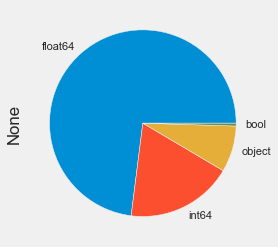

In [171]:
train_1.dtypes.value_counts().plot.pie()

In [99]:
train_1['TARGET'].value_counts()

0    282686
1    24825 
Name: TARGET, dtype: int64

In [100]:
train_1['TARGET'].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

<AxesSubplot:ylabel='Frequency'>

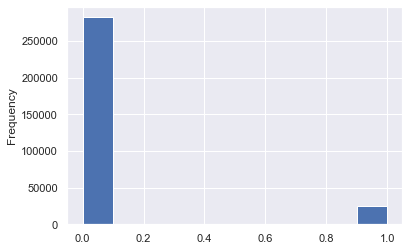

In [101]:
train_1['TARGET'].astype(int).plot.hist() # on pouvait ne pas préciser le type

% de prêt remboursé


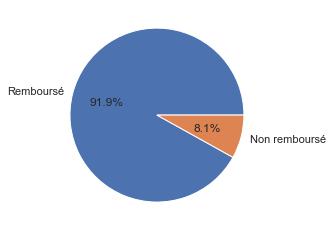

In [102]:
target_cent_train=train_1['TARGET'].value_counts()/len(train_1)*100

print('% de prêt remboursé')
plt.pie(target_cent_train,
        autopct='%1.1f%%',
        labels=["Remboursé", "Non remboursé"]
           )
plt.show()

### Examinons les valeurs manquantes (premier traitement)

Ensuite, nous pouvons examiner le nombre et le pourcentage de valeurs manquantes dans chaque colonne.  

In [103]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [104]:
missing_train_1 = missing_values_table(train_1)
missing_train_1.head(10)

Your selected dataframe has 334 columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0


In [105]:
miss_r = 90

In [106]:
missing_train_1_vars = list(missing_train_1.index[missing_train_1['% of Total Values'] > miss_r])
len(missing_train_1_vars)

0

In [107]:
missing_submit_1 = missing_values_table(submit_1)
missing_submit_1.head(10)

Your selected dataframe has 333 columns.
There are 275 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [108]:
missing_submit_1_vars = list(missing_submit_1.index[missing_submit_1['% of Total Values'] > 90])
len(missing_submit_1_vars)

0

In [109]:
missing_columns = list(set(missing_submit_1_vars + missing_train_1_vars))
print('Il y a %d colonnes avec plus de 90%% de données manquantes dans les données d\'entraînement ou de test.' % len(missing_columns))

Il y a 0 colonnes avec plus de 90% de données manquantes dans les données d'entraînement ou de test.


In [110]:
# Drop the missing columns
train_1 = train_1.drop(columns = missing_columns)
submit_1 = submit_1.drop(columns = missing_columns)

#### Anomalies

Un problème que nous voulons toujours être à l'affût lors de l'EDA est celui des anomalies dans les données. Ceux-ci peuvent être dus à des nombres mal saisis, à des erreurs dans l'équipement de mesure, ou ils peuvent être des mesures valides mais extrêmes. Une façon de prendre en charge quantitativement les anomalies consiste à examiner les statistiques d'une colonne à l'aide de la **méthode de description**. Les nombres dans la colonne DAYS_BIRTH sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons multiplier par -1 et diviser par le nombre de jours dans une année : 


In [111]:
train_1['DAYS_BIRTH'].unique

<bound method Series.unique of 0        -9461 
1        -16765
2        -19046
3        -19005
4        -19932
          ...  
307506   -9327 
307507   -20775
307508   -14966
307509   -11961
307510   -16856
Name: DAYS_BIRTH, Length: 307511, dtype: int64>

In [112]:
(train_1['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean     43.936973    
std      11.956133    
min      20.517808    
25%      34.008219    
50%      43.150685    
75%      53.923288    
max      69.120548    
Name: DAYS_BIRTH, dtype: float64

In [113]:
train_1['DAYS_EMPLOYED'].describe()

count    307511.000000
mean     63815.045904 
std      141275.766519
min     -17912.000000 
25%     -2760.000000  
50%     -1213.000000  
75%     -289.000000   
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

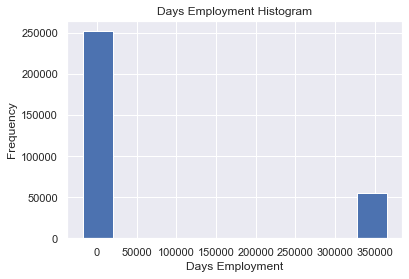

In [114]:
train_1['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [115]:
anom = train_1[train_1['DAYS_EMPLOYED'] == 365243]
non_anom = train_1[train_1['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


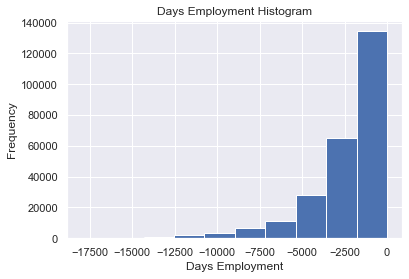

In [116]:
# Création d'une colonne 'DAYS_EMPLOYED_ANOM'
train_1['DAYS_EMPLOYED_ANOM'] = train_1["DAYS_EMPLOYED"] == 365243

# Remplacer les anomalies dans cette colonne par NaN
train_1['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

train_1['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [117]:
submit_1['DAYS_EMPLOYED_ANOM'] = submit_1["DAYS_EMPLOYED"] == 365243
submit_1["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (submit_1["DAYS_EMPLOYED_ANOM"].sum(), len(submit_1)))

There are 9274 anomalies in the test data out of 48744 entries


À partir de ces informations, nous voyons qu'il s'agit d'un problème de classe déséquilibré http://www.chioka.in/class-imbalance-problem/ . Il y a beaucoup plus de prêts qui ont été remboursés à temps que de prêts qui n'ont pas été remboursés. Une fois que nous entrons dans des modèles d'apprentissage automatique plus sophistiqués, nous pouvons pondérer les classes https://xgboost.readthedocs.io/en/latest/parameter.html par leur représentation dans les données pour refléter ce déséquilibre. 
Dans un premier temps nous allons voir regarder la **Corrélation** entre la cible et les autres variables et ensuite regarder les **valeurs manquantes**.

### Corrélations

##### Évaluer l'intérêt d'une variable avec le coefficient de Pearson

Pour déterminer si une variable est utile, nous pouvons calculer le coefficient de **corrélation de Pearson** (valeur r) entre cette variable et la cible. Cela mesure la force d'une relation linéaire entre deux variables et varie de -1 (parfaitement négativement linéaire) à +1 (parfaitement positivement linéaire).

La valeur r donne une première approximation pour savoir si une variable sera utile à un modèle d'apprentissage automatique.

**Plus la valeur r d'une variable par rapport à la cible est élevée, plus un changement dans cette variable est susceptible d'affecter la valeur de la cible**.

Nous pouvons également visualiser une relation entre une variable et la cible avec le graphique **KDE** (**Kernel Density Estimate**).

### Fonction de calcul du coefficient de corrélation de Pearson

In [118]:
# calculons toutes les correlations dans le dataframe
corrs = train_1.corr()

In [119]:
corrs = corrs.sort_values('TARGET', ascending = False)

# dix correlations positives
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
DAYS_EMPLOYED,0.074958
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606


In [120]:
# dix correlations négatives
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_MONTHS_BALANCE_count_min,-0.048224
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


Jetons un coup d'œil à certaines des corrélations les plus significatives : le DAYS_BIRTH est la corrélation la plus positive. (sauf pour TARGET car la corrélation d'une variable avec elle-même est toujours 1 !) En regardant la documentation, DAYS_BIRTH est l'âge en jours du client au moment du prêt en jours négatifs (pour quelque raison que ce soit !) . La corrélation est positive, mais la valeur de cette caractéristique est en réalité négative, ce qui signifie qu'à mesure que le client vieillit, il est moins susceptible de faire défaut sur son prêt (c'est-à-dire la cible == 0). C'est un peu déroutant, nous allons donc prendre la valeur absolue de la caractéristique et ensuite la corrélation sera négative.


### Effet de l'âge sur le remboursement

In [121]:
# Find the correlation of the positive days since birth and target
train_1['DAYS_BIRTH'] = abs(train_1['DAYS_BIRTH'])
train_1['DAYS_BIRTH'].corr(train_1['TARGET'])

-0.07823930830984513


À mesure que le client vieillit, il existe une relation linéaire négative avec la cible, ce qui signifie qu'à mesure que les clients vieillissent, ils ont tendance à rembourser leurs prêts à temps plus souvent.

Commençons par examiner cette variable. Tout d'abord, nous pouvons faire un histogramme de l'âge. Nous mettrons l'axe des x en années pour rendre l'intrigue un peu plus compréhensible.


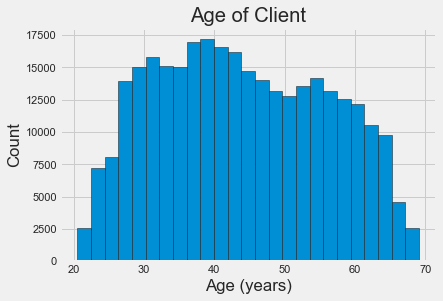

In [122]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(train_1['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

En soi, la distribution de l'âge ne nous dit pas grand-chose à part qu'il n'y a pas de valeurs aberrantes car tous les âges sont raisonnables. Pour visualiser l'effet de l'âge sur la cible, nous allons ensuite faire un [kernel density estimation plot](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) colored by the value of the target. A [kernel density estimate plot shows the distribution of a single variable](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/)et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement un gaussien, à chaque point de données, puis en faisant la moyenne de tous les noyaux individuels pour développer une seule courbe lisse) . Nous allons utiliser `kdeplot` de seaborn  pour ce graph.

### Graphique d'estimation de la densité du noyau (KDE)

Le graphique d'estimation de la densité du noyau montre la distribution d'une seule variable.

In [123]:
# Distribution d'une variable colorée par la valeur de la cible
def kde_target(var_name, df):
    
    # Calcul du coefficient de corrélation de Pearson entre une variable et la variable cible
    corr = df['TARGET'].corr(df[var_name])
    
    # Calcul des valeurs médianes
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (8, 5))
    
    # Graphe des distributions de valeurs pour la cible = 0 et 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0') # ages
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1') # ages
    
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # Corrélations
    print('La corrélation entre la variable %s et la cible est de %0.4f' % (var_name, corr))
    # Valeurs médianes
    print('Valeur médiane pour les crédits non remboursés = %0.4f' % avg_not_repaid)
    print('Valeur médiane pour les crédits remboursés = %0.4f' % avg_repaid)

La corrélation entre la variable DAYS_BIRTH et la cible est de -0.0782
Valeur médiane pour les crédits non remboursés = 14282.0000
Valeur médiane pour les crédits remboursés = 15877.0000


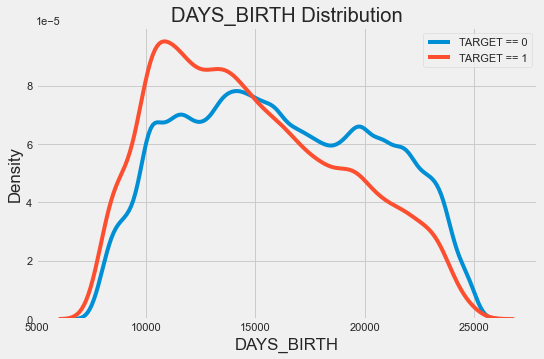

In [124]:
kde_target('DAYS_BIRTH', train_1)

**Les personnes agées ont tendance à rembourser mieux leurs crédits**.

La corrélation entre la variable bureau_CREDIT_ACTIVE_Closed_count_norm et la cible est de -0.0794
Valeur médiane pour les crédits non remboursés = 0.5000
Valeur médiane pour les crédits remboursés = 0.6250


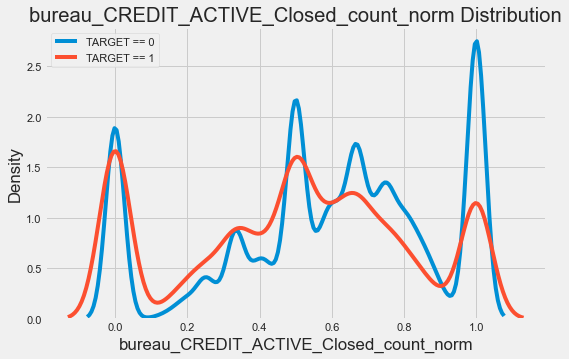

In [125]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Closed_count_norm', df=train_1)

**Cette variable aussi a un impact sur la CIBLE**.

### Sources extérieures 

Les 3 variables avec les corrélations négatives les plus fortes avec la cible sont `EXT_SOURCE_1`, `EXT_SOURCE_2` et `EXT_SOURCE_3`.
Selon la documentation, ces caractéristiques représentent un « score normalisé provenant d'une source de données externe ». Nous ne savons pas exactement ce que cela signifie, mais il peut s'agir d'une sorte de cote de crédit cumulative établie à l'aide de nombreuses sources de données.

Jetons un coup d'œil à ces variables.

Premièrement, nous pouvons montrer les corrélations des caractéristiques `EXT_SOURCE` avec la cible et entre elles. 

In [126]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = train_1[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


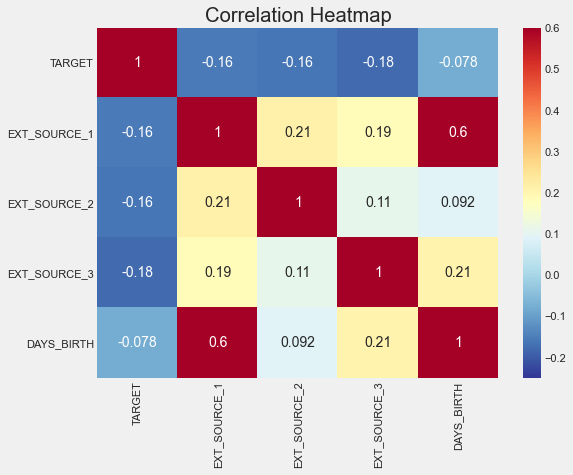

In [127]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Les trois caractéristiques `EXT_SOURCE` ont des corrélations négatives avec la cible, indiquant qu'à mesure que la valeur de `EXT_SOURCE` augmente, le client est plus susceptible de rembourser le prêt. Nous pouvons également voir que `DAYS_BIRTH` est positivement corrélé avec `EXT_SOURCE_1` indiquant que peut-être l'un des facteurs de ce score est l'âge du client.

On présente ci-dessous les graphiques KDE et les histogrammes de trois variables qui s'avèrent être assez importantes dans les processus de décision. En effet, après plusieurs tests d'entraînements de modèles de Machine Learning, les classifieurs identifient souvent ses variables comme influentes dans le choix de la décision.

La corrélation entre la variable EXT_SOURCE_1 et la cible est de -0.1553
Valeur médiane pour les crédits non remboursés = 0.3617
Valeur médiane pour les crédits remboursés = 0.5175


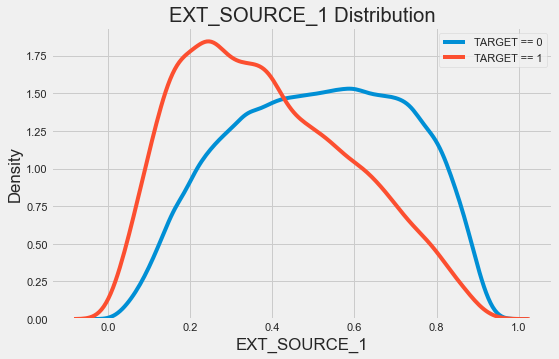

In [128]:
kde_target('EXT_SOURCE_1', train_1)

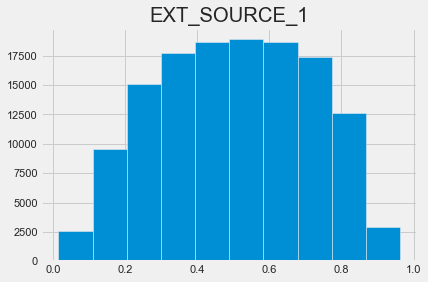

In [129]:
train_1[['EXT_SOURCE_1']].hist();

La corrélation entre la variable EXT_SOURCE_2 et la cible est de -0.1605
Valeur médiane pour les crédits non remboursés = 0.4404
Valeur médiane pour les crédits remboursés = 0.5739


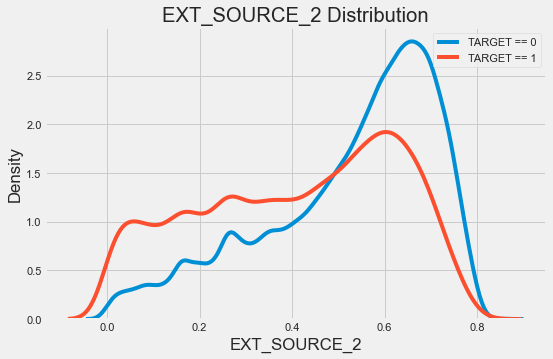

In [130]:
kde_target('EXT_SOURCE_2', train_1)

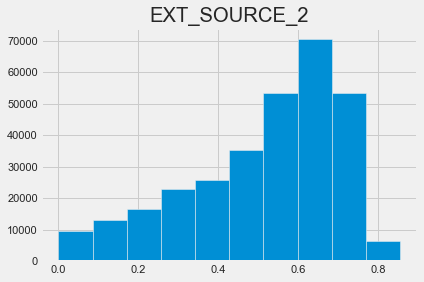

In [131]:
train_1[['EXT_SOURCE_2']].hist();

La corrélation entre la variable EXT_SOURCE_3 et la cible est de -0.1789
Valeur médiane pour les crédits non remboursés = 0.3791
Valeur médiane pour les crédits remboursés = 0.5460


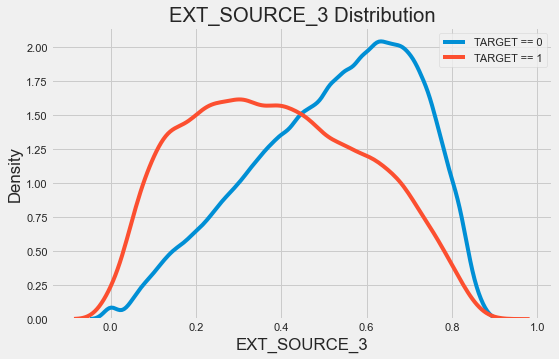

In [132]:
kde_target('EXT_SOURCE_3', train_1)

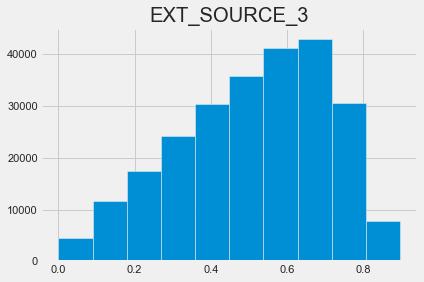

In [133]:
train_1[['EXT_SOURCE_3']].hist();

### Variables corrélées

In [134]:
# fixons un seuil à 95 %
threshold = 0.80

# Dictionnaire vide pour contenir les variables corrélées 
above_threshold_vars = {}

# Pour chaque colonne, enregistrez les variables qui sont au-dessus du seuil 
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [135]:
# Initialisation de la liste des colonnes à supprimer
cols_to_remove = []
# Initialisation de la liste des colonnes traitées
cols_seen = []
# Initialisation de la liste des colonnes à supprimer
cols_to_remove_pair = []

# Itérer à travers les colonnes et les colonnes corrélées 
for key, value in above_threshold_vars.items():
    # Gardez une trace des colonnes déjà examinées
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # supprimer qu'un dans une paire 
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  135


In [146]:
train_1_corrs_removed = train_1.drop(columns = cols_to_remove)
submit_1_corrs_removed = submit_1.drop(columns = cols_to_remove)

print('Dimensions du dataframe d\'entraînement après suppression des variables corrélées: ', train_1_corrs_removed.shape)
print('Dimensions du dataframe  de soumission après suppression des variables corrélées: ', submit_1_corrs_removed.shape)

Dimensions du dataframe d'entraînement après suppression des variables corrélées:  (307511, 200)
Dimensions du dataframe  de soumission après suppression des variables corrélées:  (48744, 199)


In [149]:
len(cols_seen), len(cols_to_remove), len(cols_to_remove_pair)

(319, 135, 596)

In [151]:
train_1 = train_1_corrs_removed
submit_1 = submit_1_corrs_removed
train_1.shape, submit_1.shape

((307511, 200), (48744, 199))

# Feature Engineering

   Le Feature Engineering consiste à extraire des caractéristiques des données brutes afin de résoudre des problèmes spécifiques à un domaine d’activité grâce au Machine Learning.
   Le **feature engineering** a un meilleur retour sur investissement que la création de modèles et le réglage des hyperparamètres. Comme **Andrew NG aime le dire** : **"l'apprentissage automatique appliqué est essentiellement de le feature engineering"**.

Bien qu'il soit important de choisir le bon modèle et les paramètres optimaux, le modèle ne peut apprendre qu'à partir des données qui lui sont fournies. S'assurer que ces données sont aussi pertinentes que possible pour la tâche est le travail des scientifiques des données (et peut-être des outils automatisés pour nous aider).

**L'ingénierie des fonctionnalités** fait référence à un processus général et peut impliquer à la fois la construction de fonctionnalités : ajouter de nouvelles fonctionnalités à partir des données existantes, et la **Feature Selection ou sélection de caractéristiques** : choisir uniquement les caractéristiques les plus importantes ou d'autres méthodes de réduction de la dimensionnalité. Il existe de nombreuses techniques que nous pouvons utiliser pour créer des caractéristiques et sélectionner des caractéristiques.

Nous ferons beaucoup d'ingénierie de caractéristiques lorsque nous commencerons à utiliser les autres sources de données, mais dans ce cahier, nous n'essaierons que deux méthodes de construction de caractéristiques simples: 

* **Ploynomial features**
* **Domain knowledge features**

## <span style="color: ##0101DF;"> Domain knowledge features </span> 

"tentatives d'appliquer des connaissances financières limitées". Dans cet état d'esprit, nous pouvons créer quelques fonctionnalités qui tentent de capturer ce que nous pensons être important pour savoir si un client ne remboursera pas un prêt. Ici, je vais utiliser cinq fonctionnalités qui ont été inspirées par [this script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) par **Aguiar**:

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income (le pourcentage du montant du crédit par rapport aux revenus d'un client)
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income (le pourcentage de la rente du prêt par rapport aux revenus d'un client)
* `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due (la durée du versement en mois (puisque la rente est le montant mensuel dû)
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age (le pourcentage des jours occupés par rapport à l'âge du client)

Again, thanks to Aguiar and [his great script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) for exploring these features.

In [152]:
train_1_domain = train_1.copy()

train_1_domain['CREDIT_INCOME_PERCENT'] = train_1_domain['AMT_CREDIT'] / train_1_domain['AMT_INCOME_TOTAL']
train_1_domain['ANNUITY_INCOME_PERCENT'] = train_1_domain['AMT_ANNUITY'] / train_1_domain['AMT_INCOME_TOTAL']
train_1_domain['CREDIT_TERM'] = train_1_domain['AMT_ANNUITY'] / train_1_domain['AMT_CREDIT']
train_1_domain['DAYS_EMPLOYED_PERCENT'] = train_1_domain['DAYS_EMPLOYED'] / train_1_domain['DAYS_BIRTH']

In [153]:
submit_1_domain = submit_1.copy()

submit_1_domain['CREDIT_INCOME_PERCENT'] = submit_1_domain['AMT_CREDIT'] / submit_1_domain['AMT_INCOME_TOTAL']
submit_1_domain['ANNUITY_INCOME_PERCENT'] = submit_1_domain['AMT_ANNUITY'] / submit_1_domain['AMT_INCOME_TOTAL']
submit_1_domain['CREDIT_TERM'] = submit_1_domain['AMT_ANNUITY'] / submit_1_domain['AMT_CREDIT']
submit_1_domain['DAYS_EMPLOYED_PERCENT'] = submit_1_domain['DAYS_EMPLOYED'] / submit_1_domain['DAYS_BIRTH']

#### Visualisation des nouvelles variables

Nous devrions explorer ces variables de __domaine de connaissance__ visuellement dans un graphique. Pour tous ces éléments, nous allons créer le même tracé KDE coloré par la valeur de `TARGET`. 

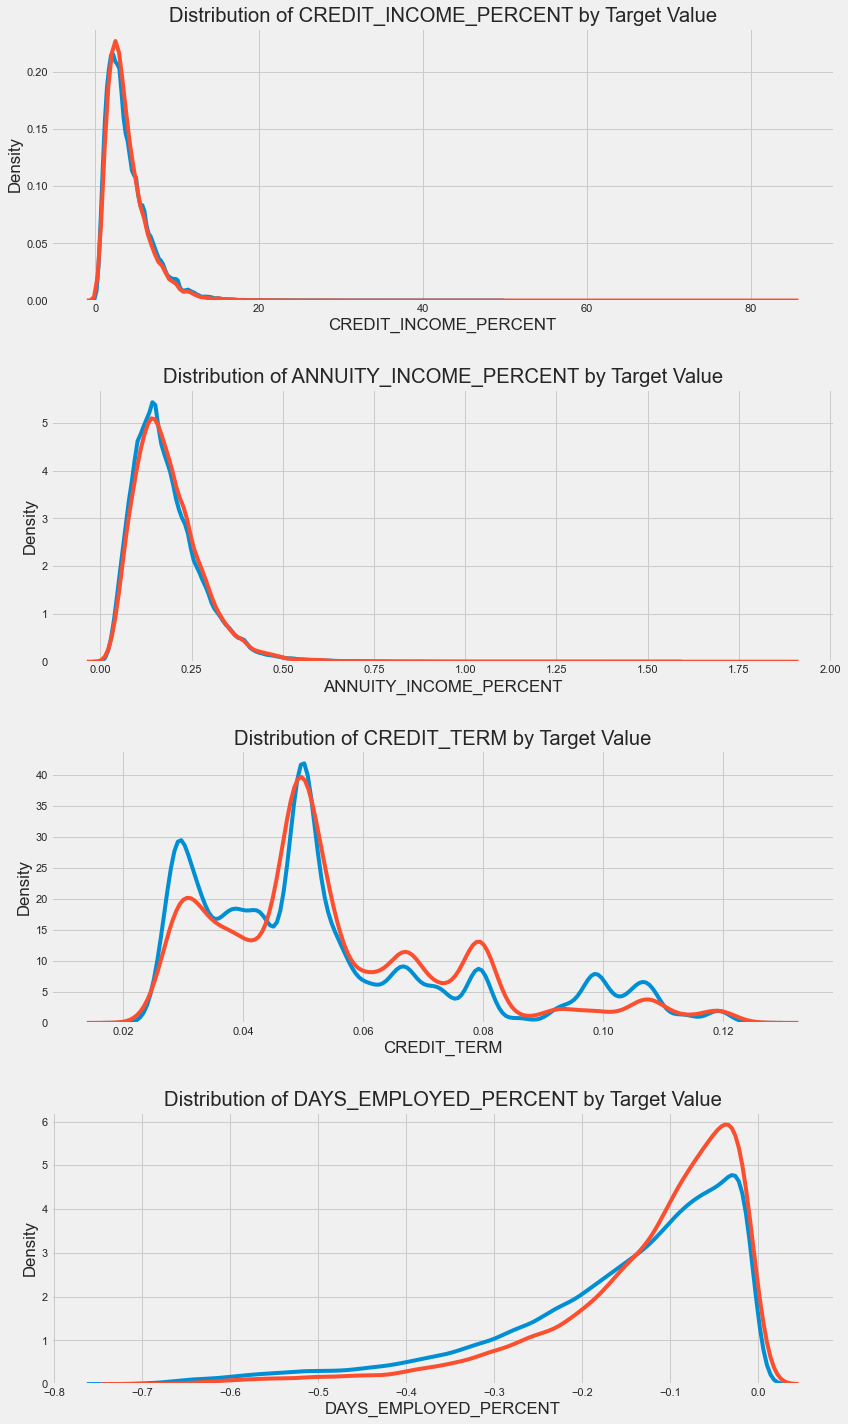

In [154]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # création des courbes ens
    plt.subplot(4, 1, i + 1)
    # courbes prêts remboursés 
    sns.kdeplot(train_1_domain.loc[train_1_domain['TARGET'] == 0, feature], label = 'target == 0')
    # courbes des prêts non remboursés
    sns.kdeplot(train_1_domain.loc[train_1_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # labels
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

### les dataframes à conserver pour la suite

In [155]:
train_1 = train_1.replace([np.inf, -np.inf], np.nan)
submit_1 = submit_1.replace([np.inf, -np.inf], np.nan)

train_1_domain = train_1_domain.replace([np.inf, -np.inf], np.nan)
submit_1_domain = submit_1_domain.replace([np.inf, -np.inf], np.nan)

In [156]:
train_1.shape, submit_1.shape

((307511, 200), (48744, 199))

In [157]:
train_1_domain.shape, submit_1_domain.shape

((307511, 204), (48744, 203))

In [158]:
import re
train_1_domain = train_1_domain.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
submit_1_domain = submit_1_domain.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [159]:
joblib.dump(train_1_domain, path_data+'train_1_domain.joblib')
joblib.dump(submit_1_domain, path_data+'submit_1_domain.joblib')

['C:/Users/Agboto/Desktop/Projet_OpenClassrooms_Data_Science/Projet7_openclassrooms/submit_1_domain.joblib']